
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # End of episodes/goal/task where nextQs = 0 and Qs=rs
    dones = tf.placeholder(tf.bool, [None], name='dones') # masked

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    nextQs_D = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, dones, nextQs, nextQs_D

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, # model input data for Qs/qs/rs 
               nextQs, gamma, # model input data for targetQs
               state_size, action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = generator(prev_actions=prev_actions_onehot, states=states, 
                                  hidden_size=hidden_size, state_size=state_size, action_size=action_size)
    
    # Masking actions_logits unmasked
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    qs = tf.sigmoid(Qs) # qt
    targetQs = qs + (gamma * nextQs)
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - targetQs))

    return actions_logits, q_loss

In [10]:
# Outputing the unmasked nextQs for D to be used as the target/label
def model_output(actions, next_states,
                 action_size, hidden_size):
    # Discriminator for nextQs_D
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_D_unmasked = discriminator(prev_actions=actions_onehot, states=next_states, hidden_size=hidden_size)
    
    # Returning unmasked nextQs_D to masked using dones/ends of episodes
    return nextQs_D_unmasked

In [11]:
# The model loss for the NEW idea G & D
def model_loss2(nextQs_D, gamma, 
                prev_actions, states, 
                action_size, hidden_size):
    # Calculating Qs total rewards using Discriminator
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    Qs = discriminator(prev_actions=prev_actions_onehot, states=states, hidden_size=hidden_size, reuse=True)
        
    # Bellman equaion: Qs = rt/qt + nextQs_G/D
    qs = tf.sigmoid(Qs) # qt
    targetQs_D = qs + (gamma * nextQs_D)
    
    # Calculating the loss: logits/predictions vs labels
    d_loss = tf.reduce_mean(tf.square(Qs - targetQs_D))
    return d_loss

In [12]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss3(nextQs_D, gamma,
                prev_actions, states, dones, 
                state_size, action_size, hidden_size):
    # Generator for nextQs_G
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_G
    nextQs_G_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                      hidden_size=hidden_size, reuse=True)
    
    # Masking the unmasked nextQs_G using dones/end of episodes/goal
    dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_G_unmasked.dtype, x=dones)), shape=[-1, 1])
    nextQs_G_masked = tf.multiply(nextQs_G_unmasked, dones_mask)
    nextQs_G = tf.reduce_max(axis=1, input_tensor=nextQs_G_masked)

    # Below is the idea behind this loss
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_G = qs + (gamma * nextQs_G)
    # targetQs_D = qs + (gamma * nextQs_D)
    # targetQs_G = targetQs_D
    # nextQs_G = nextQs_D 
    # Calculating the loss: logits/predictions vs labels
    g_loss = tf.reduce_mean(tf.square(nextQs_G - nextQs_D))
    
    # Returning g_loss which should impact Generator
    return g_loss

In [13]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Generator loss for action prediction
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars) # action prediction
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return q_opt, g_opt, d_opt

In [14]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.dones, self.nextQs, self.nextQs_D = model_input(
            state_size=state_size)

        # Output of the Model
        self.nextQs_D_unmasked = model_output(actions=self.actions, next_states=self.next_states,
                                              action_size=action_size, hidden_size=hidden_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.q_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            prev_actions=self.prev_actions, states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Loss of the model: reward prob/logits prediction
        self.d_loss = model_loss2(nextQs_D=self.nextQs_D, gamma=gamma,
                                  action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        # Loss of the model: states prediction/generation
        self.g_loss = model_loss3(nextQs_D=self.nextQs_D, gamma=gamma, dones=self.dones,
                                  state_size=state_size, action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, 
                                                       g_loss=self.g_loss, 
                                                       d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [15]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [16]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [17]:
train_episodes = 10000         # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [18]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [20]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, reward, done, info = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()# At
    next_state, reward, done, info = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        
        # Print out reward and done and check if they are the same: They are NOT.
        #print('if done is true:', reward, done)
        
        # # the episode ends so no next state
        # next_state = np.zeros(state.shape)
                
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, reward, done, info = env.step(prev_action)
    else:
        # Print out reward and done and check if they are the same!
        #print('else done is false:', reward, done)
        
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [21]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, reward, done, info = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, info = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #print(prev_actions.shape, states.shape, actions.shape, next_states.shape, dones.shape, dones.dtype)
            #print(dones[:3])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, 
                       model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # Calculating nextQs for Discriminator using D(At, St+1)= Qt+1/nextQs_D/nextQs
            # Calculating nextQs for Discriminator using D(~At, ~St+1)= ~Qt+1/nextQs_G/nextQs2
            feed_dict={model.prev_actions: prev_actions, model.states: states,
                       model.actions: actions, model.next_states: next_states}
            nextQs_D_unmasked = sess.run(model.nextQs_D_unmasked, feed_dict)
            
            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_D_unmasked[0].dtype)).reshape(-1, 1)
            nextQs_D_masked = np.multiply(nextQs_D_unmasked[0], dones_mask)
            nextQs_D = np.max(nextQs_D_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # D(At-1, St)= Qs and qs = tf.sigmoid(Qs)
            # NextQs/Qt+1 are given both:
            # targetQs = qs + gamma * nextQs_G
            # targetQs = qs + gamma * nextQs_D
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.dones: dones,
                         model.nextQs: nextQs,
                         model.nextQs_D: nextQs_D}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 3.0 Training q_loss: 0.3319 Training g_loss: 0.0153 Training d_loss: 0.1670 Explore P: 0.9997
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 34.0 Training q_loss: 0.6930 Training g_loss: 0.7829 Training d_loss: 1.2712 Explore P: 0.9963
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 15.0 Training q_loss: 0.4860 Training g_loss: 0.1517 Training d_loss: 4.9132 Explore P: 0.9949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 36.0 Training q_loss: 0.4252 Training g_loss: 0.0602 Tra

-------------------------------------------------------------------------------
Episode: 30 Total reward: 39.0 Training q_loss: 0.4647 Training g_loss: 0.2724 Training d_loss: 12.0865 Explore P: 0.9429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 31 Total reward: 16.0 Training q_loss: 0.4657 Training g_loss: 0.3004 Training d_loss: 13.1454 Explore P: 0.9414
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 12.0 Training q_loss: 0.4454 Training g_loss: 0.2213 Training d_loss: 26.5687 Explore P: 0.9403
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 44.0 Training q_loss: 0.4885 Training g_loss: 0.

-------------------------------------------------------------------------------
Episode: 60 Total reward: 12.0 Training q_loss: 0.4613 Training g_loss: 0.1615 Training d_loss: 19.2593 Explore P: 0.8864
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 61 Total reward: 22.0 Training q_loss: 0.4465 Training g_loss: 0.3353 Training d_loss: 11.9927 Explore P: 0.8845
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 62 Total reward: 20.0 Training q_loss: 0.4654 Training g_loss: 0.1487 Training d_loss: 16.4736 Explore P: 0.8827
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 63 Total reward: 37.0 Training q_loss: 0.4533 Training g_loss: 0.

-------------------------------------------------------------------------------
Episode: 90 Total reward: 22.0 Training q_loss: 0.4412 Training g_loss: 0.4632 Training d_loss: 14.3897 Explore P: 0.8375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 91 Total reward: 38.0 Training q_loss: 0.4286 Training g_loss: 0.3905 Training d_loss: 8.0241 Explore P: 0.8344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 92 Total reward: 17.0 Training q_loss: 0.4166 Training g_loss: 0.0891 Training d_loss: 19.9363 Explore P: 0.8330
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 16.0 Training q_loss: 0.4324 Training g_loss: 0.1

-------------------------------------------------------------------------------
Episode: 120 Total reward: 15.0 Training q_loss: 0.4788 Training g_loss: 0.3495 Training d_loss: 15.1281 Explore P: 0.7924
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 121 Total reward: 15.0 Training q_loss: 0.4944 Training g_loss: 0.3782 Training d_loss: 13.9540 Explore P: 0.7912
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 122 Total reward: 12.0 Training q_loss: 0.5077 Training g_loss: 0.3963 Training d_loss: 16.9554 Explore P: 0.7902
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 123 Total reward: 9.0 Training q_loss: 0.5260 Training g_loss:

-------------------------------------------------------------------------------
Episode: 149 Total reward: 9.0 Training q_loss: 0.5245 Training g_loss: 1.2062 Training d_loss: 10.9954 Explore P: 0.7542
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 150 Total reward: 17.0 Training q_loss: 0.5227 Training g_loss: 0.3644 Training d_loss: 14.2420 Explore P: 0.7529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 151 Total reward: 19.0 Training q_loss: 0.4910 Training g_loss: 0.2035 Training d_loss: 14.9683 Explore P: 0.7515
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 152 Total reward: 12.0 Training q_loss: 0.4818 Training g_loss:

-------------------------------------------------------------------------------
Episode: 178 Total reward: 18.0 Training q_loss: 0.5455 Training g_loss: 0.7009 Training d_loss: 13.3728 Explore P: 0.7208
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 179 Total reward: 15.0 Training q_loss: 0.5719 Training g_loss: 0.6407 Training d_loss: 9.5179 Explore P: 0.7197
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 180 Total reward: 14.0 Training q_loss: 0.5463 Training g_loss: 0.5597 Training d_loss: 11.4273 Explore P: 0.7188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 181 Total reward: 10.0 Training q_loss: 0.5472 Training g_loss:

-------------------------------------------------------------------------------
Episode: 209 Total reward: 9.0 Training q_loss: 0.4816 Training g_loss: 0.2398 Training d_loss: 15.1457 Explore P: 0.6837
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 39.0 Training q_loss: 0.5649 Training g_loss: 0.5094 Training d_loss: 11.9616 Explore P: 0.6811
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 13.0 Training q_loss: 0.6695 Training g_loss: 0.9387 Training d_loss: 9.2622 Explore P: 0.6802
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 15.0 Training q_loss: 0.5894 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 239 Total reward: 11.0 Training q_loss: 0.5904 Training g_loss: 0.5074 Training d_loss: 12.0255 Explore P: 0.6454
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 240 Total reward: 12.0 Training q_loss: 0.6316 Training g_loss: 0.7663 Training d_loss: 7.4827 Explore P: 0.6447
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 241 Total reward: 11.0 Training q_loss: 0.5958 Training g_loss: 0.5576 Training d_loss: 8.5386 Explore P: 0.6440
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 242 Total reward: 13.0 Training q_loss: 0.6328 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 268 Total reward: 16.0 Training q_loss: 0.6838 Training g_loss: 0.3388 Training d_loss: 18.5972 Explore P: 0.6212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 269 Total reward: 30.0 Training q_loss: 0.7085 Training g_loss: 0.6332 Training d_loss: 9.5787 Explore P: 0.6194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 270 Total reward: 23.0 Training q_loss: 0.6690 Training g_loss: 0.5452 Training d_loss: 10.9310 Explore P: 0.6180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 271 Total reward: 11.0 Training q_loss: 0.6149 Training g_loss:

-------------------------------------------------------------------------------
Episode: 297 Total reward: 57.0 Training q_loss: 34.8322 Training g_loss: 0.0829 Training d_loss: 16.4107 Explore P: 0.5794
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 298 Total reward: 66.0 Training q_loss: 31.9141 Training g_loss: 0.0468 Training d_loss: 22.6435 Explore P: 0.5757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 299 Total reward: 41.0 Training q_loss: 32.8507 Training g_loss: 0.0237 Training d_loss: 8.5139 Explore P: 0.5734
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 33.0 Training q_loss: 32.9248 Training g_l

-------------------------------------------------------------------------------
Episode: 326 Total reward: 45.0 Training q_loss: 31.4252 Training g_loss: 0.1141 Training d_loss: 12.4144 Explore P: 0.5077
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 327 Total reward: 39.0 Training q_loss: 30.5110 Training g_loss: 0.0367 Training d_loss: 10.7700 Explore P: 0.5057
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 328 Total reward: 45.0 Training q_loss: 31.7668 Training g_loss: 0.4656 Training d_loss: 10.9768 Explore P: 0.5035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 329 Total reward: 91.0 Training q_loss: 27.9091 Training g_

-------------------------------------------------------------------------------
Episode: 355 Total reward: 92.0 Training q_loss: 18.3459 Training g_loss: 0.5107 Training d_loss: 18.9314 Explore P: 0.4388
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 356 Total reward: 35.0 Training q_loss: 18.7576 Training g_loss: 0.0086 Training d_loss: 21.1130 Explore P: 0.4373
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 357 Total reward: 32.0 Training q_loss: 20.3984 Training g_loss: 0.0414 Training d_loss: 13.9924 Explore P: 0.4359
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 358 Total reward: 49.0 Training q_loss: 18.6370 Training g_

-------------------------------------------------------------------------------
Episode: 384 Total reward: 60.0 Training q_loss: 15.0980 Training g_loss: 0.0390 Training d_loss: 18.6706 Explore P: 0.3757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 385 Total reward: 86.0 Training q_loss: 15.6518 Training g_loss: 0.1312 Training d_loss: 19.4277 Explore P: 0.3726
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 386 Total reward: 63.0 Training q_loss: 17.7502 Training g_loss: 0.0187 Training d_loss: 7.9069 Explore P: 0.3703
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 387 Total reward: 38.0 Training q_loss: 16.8461 Training g_l

-------------------------------------------------------------------------------
Episode: 413 Total reward: 31.0 Training q_loss: 7.7232 Training g_loss: 0.0203 Training d_loss: 8.8572 Explore P: 0.3239
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 414 Total reward: 32.0 Training q_loss: 6.6302 Training g_loss: 0.1054 Training d_loss: 17.7116 Explore P: 0.3229
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 415 Total reward: 42.0 Training q_loss: 7.2675 Training g_loss: 0.0408 Training d_loss: 11.9984 Explore P: 0.3216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 72.0 Training q_loss: 7.3343 Training g_loss:

-------------------------------------------------------------------------------
Episode: 442 Total reward: 30.0 Training q_loss: 5.7241 Training g_loss: 0.0296 Training d_loss: 9.6054 Explore P: 0.2771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 443 Total reward: 29.0 Training q_loss: 5.2633 Training g_loss: 0.0333 Training d_loss: 2.8098 Explore P: 0.2763
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 444 Total reward: 20.0 Training q_loss: 4.6378 Training g_loss: 0.0282 Training d_loss: 19.9319 Explore P: 0.2758
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 445 Total reward: 26.0 Training q_loss: 5.2331 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 471 Total reward: 19.0 Training q_loss: 5.1216 Training g_loss: 0.0078 Training d_loss: 15.9945 Explore P: 0.2594
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 472 Total reward: 23.0 Training q_loss: 6.7481 Training g_loss: 0.0150 Training d_loss: 17.0886 Explore P: 0.2588
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 473 Total reward: 23.0 Training q_loss: 7.0354 Training g_loss: 0.0210 Training d_loss: 12.1064 Explore P: 0.2583
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 474 Total reward: 21.0 Training q_loss: 6.8825 Training g_loss

-------------------------------------------------------------------------------
Episode: 500 Total reward: 33.0 Training q_loss: 8.8803 Training g_loss: 0.0044 Training d_loss: 14.7662 Explore P: 0.2422
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 501 Total reward: 24.0 Training q_loss: 6.6288 Training g_loss: 0.0305 Training d_loss: 12.6069 Explore P: 0.2417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 502 Total reward: 22.0 Training q_loss: 4.3013 Training g_loss: 0.0317 Training d_loss: 11.4848 Explore P: 0.2412
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 503 Total reward: 27.0 Training q_loss: 8.2322 Training g_loss

-------------------------------------------------------------------------------
Episode: 529 Total reward: 21.0 Training q_loss: 4.6888 Training g_loss: 0.0895 Training d_loss: 8.7024 Explore P: 0.2277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 530 Total reward: 26.0 Training q_loss: 6.8876 Training g_loss: 0.0110 Training d_loss: 18.1651 Explore P: 0.2271
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 531 Total reward: 36.0 Training q_loss: 6.9398 Training g_loss: 0.0282 Training d_loss: 20.0247 Explore P: 0.2263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 25.0 Training q_loss: 7.2096 Training g_loss:

-------------------------------------------------------------------------------
Episode: 558 Total reward: 14.0 Training q_loss: 7.6474 Training g_loss: 0.1178 Training d_loss: 15.6368 Explore P: 0.2164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 559 Total reward: 10.0 Training q_loss: 7.6421 Training g_loss: 0.0135 Training d_loss: 17.9123 Explore P: 0.2162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 560 Total reward: 11.0 Training q_loss: 7.9407 Training g_loss: 0.0427 Training d_loss: 18.7384 Explore P: 0.2160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 561 Total reward: 15.0 Training q_loss: 7.8547 Training g_loss

-------------------------------------------------------------------------------
Episode: 588 Total reward: 12.0 Training q_loss: 7.0097 Training g_loss: 0.0986 Training d_loss: 13.4781 Explore P: 0.2077
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 589 Total reward: 17.0 Training q_loss: 8.5482 Training g_loss: 0.0736 Training d_loss: 10.1912 Explore P: 0.2074
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 590 Total reward: 10.0 Training q_loss: 8.2104 Training g_loss: 0.0304 Training d_loss: 15.1304 Explore P: 0.2072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 591 Total reward: 13.0 Training q_loss: 7.6963 Training g_loss

-------------------------------------------------------------------------------
Episode: 617 Total reward: 19.0 Training q_loss: 7.9948 Training g_loss: 0.0806 Training d_loss: 14.2486 Explore P: 0.1990
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 618 Total reward: 14.0 Training q_loss: 8.0263 Training g_loss: 0.0101 Training d_loss: 25.2679 Explore P: 0.1987
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 619 Total reward: 13.0 Training q_loss: 8.0528 Training g_loss: 0.0668 Training d_loss: 18.2320 Explore P: 0.1984
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 620 Total reward: 17.0 Training q_loss: 8.2199 Training g_loss

-------------------------------------------------------------------------------
Episode: 646 Total reward: 16.0 Training q_loss: 7.4063 Training g_loss: 0.2276 Training d_loss: 15.0275 Explore P: 0.1891
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 647 Total reward: 13.0 Training q_loss: 7.5243 Training g_loss: 0.0203 Training d_loss: 9.1529 Explore P: 0.1889
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 648 Total reward: 22.0 Training q_loss: 7.6138 Training g_loss: 0.0233 Training d_loss: 20.7851 Explore P: 0.1885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 649 Total reward: 28.0 Training q_loss: 7.7604 Training g_loss:

-------------------------------------------------------------------------------
Episode: 675 Total reward: 46.0 Training q_loss: 6.7914 Training g_loss: 0.0234 Training d_loss: 16.1567 Explore P: 0.1760
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 676 Total reward: 66.0 Training q_loss: 7.0389 Training g_loss: 0.0110 Training d_loss: 10.2577 Explore P: 0.1749
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 677 Total reward: 47.0 Training q_loss: 6.2227 Training g_loss: 0.0650 Training d_loss: 24.9087 Explore P: 0.1742
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 678 Total reward: 34.0 Training q_loss: 6.0119 Training g_loss

-------------------------------------------------------------------------------
Episode: 704 Total reward: 199.0 Training q_loss: 3.5902 Training g_loss: 0.0045 Training d_loss: 13.7140 Explore P: 0.1419
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 705 Total reward: 70.0 Training q_loss: 3.6765 Training g_loss: 0.0020 Training d_loss: 10.9912 Explore P: 0.1410
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 706 Total reward: 100.0 Training q_loss: 3.8557 Training g_loss: 0.0130 Training d_loss: 17.5533 Explore P: 0.1397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 707 Total reward: 122.0 Training q_loss: 3.2091 Training g_l

-------------------------------------------------------------------------------
Episode: 733 Total reward: 25.0 Training q_loss: 2.7796 Training g_loss: 0.0344 Training d_loss: 14.2468 Explore P: 0.1232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 734 Total reward: 22.0 Training q_loss: 2.9436 Training g_loss: 0.0746 Training d_loss: 29.8028 Explore P: 0.1229
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 735 Total reward: 18.0 Training q_loss: 3.3711 Training g_loss: 0.1231 Training d_loss: 22.7976 Explore P: 0.1227
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 736 Total reward: 28.0 Training q_loss: 4.2020 Training g_loss

-------------------------------------------------------------------------------
Episode: 762 Total reward: 33.0 Training q_loss: 5.0169 Training g_loss: 0.0114 Training d_loss: 15.6016 Explore P: 0.1078
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 44.0 Training q_loss: 4.6791 Training g_loss: 0.0149 Training d_loss: 15.7297 Explore P: 0.1074
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 764 Total reward: 35.0 Training q_loss: 4.5969 Training g_loss: 0.0222 Training d_loss: 23.5960 Explore P: 0.1071
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 765 Total reward: 51.0 Training q_loss: 4.7534 Training g_loss

-------------------------------------------------------------------------------
Episode: 791 Total reward: 28.0 Training q_loss: 2.0835 Training g_loss: 0.0899 Training d_loss: 20.5706 Explore P: 0.1008
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 792 Total reward: 22.0 Training q_loss: 2.3299 Training g_loss: 0.0602 Training d_loss: 35.3453 Explore P: 0.1006
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 793 Total reward: 18.0 Training q_loss: 2.2237 Training g_loss: 0.0775 Training d_loss: 28.8958 Explore P: 0.1005
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 794 Total reward: 24.0 Training q_loss: 2.0296 Training g_loss

-------------------------------------------------------------------------------
Episode: 820 Total reward: 88.0 Training q_loss: 4.0469 Training g_loss: 0.0184 Training d_loss: 16.8508 Explore P: 0.0877
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 821 Total reward: 54.0 Training q_loss: 3.5442 Training g_loss: 0.0210 Training d_loss: 25.4027 Explore P: 0.0873
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 822 Total reward: 26.0 Training q_loss: 3.1767 Training g_loss: 0.0432 Training d_loss: 10.4259 Explore P: 0.0871
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 823 Total reward: 52.0 Training q_loss: 4.5083 Training g_loss

-------------------------------------------------------------------------------
Episode: 849 Total reward: 50.0 Training q_loss: 5.3663 Training g_loss: 0.0129 Training d_loss: 19.5384 Explore P: 0.0753
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 850 Total reward: 101.0 Training q_loss: 5.9391 Training g_loss: 0.0084 Training d_loss: 9.3301 Explore P: 0.0746
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 851 Total reward: 98.0 Training q_loss: 6.3462 Training g_loss: 0.0406 Training d_loss: 10.6643 Explore P: 0.0740
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 852 Total reward: 87.0 Training q_loss: 6.5233 Training g_loss

-------------------------------------------------------------------------------
Episode: 878 Total reward: 89.0 Training q_loss: 5.1383 Training g_loss: 0.0159 Training d_loss: 24.3955 Explore P: 0.0643
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 879 Total reward: 68.0 Training q_loss: 6.7772 Training g_loss: 0.0303 Training d_loss: 9.6841 Explore P: 0.0640
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 880 Total reward: 70.0 Training q_loss: 6.4863 Training g_loss: 0.0529 Training d_loss: 19.6069 Explore P: 0.0636
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 881 Total reward: 71.0 Training q_loss: 4.7541 Training g_loss:

-------------------------------------------------------------------------------
Episode: 907 Total reward: 40.0 Training q_loss: 6.1697 Training g_loss: 0.0282 Training d_loss: 9.8841 Explore P: 0.0550
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 908 Total reward: 45.0 Training q_loss: 7.9167 Training g_loss: 0.0580 Training d_loss: 12.4587 Explore P: 0.0548
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 909 Total reward: 50.0 Training q_loss: 7.4659 Training g_loss: 0.0260 Training d_loss: 17.2572 Explore P: 0.0546
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 910 Total reward: 55.0 Training q_loss: 8.5352 Training g_loss:

-------------------------------------------------------------------------------
Episode: 936 Total reward: 81.0 Training q_loss: 11.7874 Training g_loss: 0.0281 Training d_loss: 20.4109 Explore P: 0.0495
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 53.0 Training q_loss: 11.9841 Training g_loss: 0.0104 Training d_loss: 11.3523 Explore P: 0.0493
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 938 Total reward: 51.0 Training q_loss: 9.9725 Training g_loss: 0.0132 Training d_loss: 25.8234 Explore P: 0.0491
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 939 Total reward: 46.0 Training q_loss: 11.1515 Training g_l

-------------------------------------------------------------------------------
Episode: 965 Total reward: 57.0 Training q_loss: 11.6626 Training g_loss: 0.0346 Training d_loss: 14.7352 Explore P: 0.0437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 966 Total reward: 47.0 Training q_loss: 9.9406 Training g_loss: 0.0093 Training d_loss: 6.5246 Explore P: 0.0436
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 967 Total reward: 37.0 Training q_loss: 7.5301 Training g_loss: 0.0396 Training d_loss: 12.1411 Explore P: 0.0434
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 968 Total reward: 49.0 Training q_loss: 12.8164 Training g_los

-------------------------------------------------------------------------------
Episode: 994 Total reward: 129.0 Training q_loss: 12.4624 Training g_loss: 0.0589 Training d_loss: 13.6058 Explore P: 0.0371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 995 Total reward: 57.0 Training q_loss: 14.7694 Training g_loss: 0.0171 Training d_loss: 37.7773 Explore P: 0.0369
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 996 Total reward: 70.0 Training q_loss: 11.9038 Training g_loss: 0.0209 Training d_loss: 15.4949 Explore P: 0.0368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 997 Total reward: 52.0 Training q_loss: 15.4136 Training g

-------------------------------------------------------------------------------
Episode: 1023 Total reward: 49.0 Training q_loss: 20.6123 Training g_loss: 0.0097 Training d_loss: 19.4188 Explore P: 0.0332
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1024 Total reward: 22.0 Training q_loss: 19.6571 Training g_loss: 0.0080 Training d_loss: 15.5690 Explore P: 0.0331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1025 Total reward: 32.0 Training q_loss: 19.2638 Training g_loss: 0.0008 Training d_loss: 6.8735 Explore P: 0.0330
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1026 Total reward: 64.0 Training q_loss: 18.0178 Training

-------------------------------------------------------------------------------
Episode: 1053 Total reward: 16.0 Training q_loss: 18.9626 Training g_loss: 0.0292 Training d_loss: 7.0215 Explore P: 0.0321
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1054 Total reward: 16.0 Training q_loss: 20.1845 Training g_loss: 0.0280 Training d_loss: 25.4174 Explore P: 0.0320
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1055 Total reward: 13.0 Training q_loss: 19.8554 Training g_loss: 0.0282 Training d_loss: 10.1957 Explore P: 0.0320
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1056 Total reward: 11.0 Training q_loss: 18.1267 Training

-------------------------------------------------------------------------------
Episode: 1082 Total reward: 21.0 Training q_loss: 20.1154 Training g_loss: 0.0024 Training d_loss: 6.7855 Explore P: 0.0313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1083 Total reward: 12.0 Training q_loss: 20.4502 Training g_loss: 0.0034 Training d_loss: 12.1669 Explore P: 0.0312
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1084 Total reward: 8.0 Training q_loss: 20.7258 Training g_loss: 0.0026 Training d_loss: 23.7162 Explore P: 0.0312
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1085 Total reward: 15.0 Training q_loss: 20.5666 Training 

-------------------------------------------------------------------------------
Episode: 1112 Total reward: 27.0 Training q_loss: 19.9573 Training g_loss: 0.0123 Training d_loss: 9.4496 Explore P: 0.0305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1113 Total reward: 12.0 Training q_loss: 18.9234 Training g_loss: 0.0103 Training d_loss: 15.7225 Explore P: 0.0304
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1114 Total reward: 24.0 Training q_loss: 19.2920 Training g_loss: 0.0138 Training d_loss: 10.5183 Explore P: 0.0304
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1115 Total reward: 8.0 Training q_loss: 18.9731 Training 

-------------------------------------------------------------------------------
Episode: 1141 Total reward: 9.0 Training q_loss: 19.2513 Training g_loss: 0.0467 Training d_loss: 3.4572 Explore P: 0.0298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1142 Total reward: 9.0 Training q_loss: 18.7989 Training g_loss: 0.0062 Training d_loss: 24.5856 Explore P: 0.0297
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1143 Total reward: 7.0 Training q_loss: 18.9517 Training g_loss: 0.0174 Training d_loss: 19.5099 Explore P: 0.0297
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1144 Total reward: 8.0 Training q_loss: 18.0667 Training g_l

-------------------------------------------------------------------------------
Episode: 1170 Total reward: 7.0 Training q_loss: 18.7658 Training g_loss: 0.0034 Training d_loss: 15.5794 Explore P: 0.0290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1171 Total reward: 8.0 Training q_loss: 18.4648 Training g_loss: 0.0068 Training d_loss: 26.9122 Explore P: 0.0290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1172 Total reward: 9.0 Training q_loss: 17.7555 Training g_loss: 0.0021 Training d_loss: 33.6902 Explore P: 0.0290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1173 Total reward: 18.0 Training q_loss: 18.3304 Training g

-------------------------------------------------------------------------------
Episode: 1200 Total reward: 24.0 Training q_loss: 16.0001 Training g_loss: 0.0512 Training d_loss: 17.9652 Explore P: 0.0282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1201 Total reward: 21.0 Training q_loss: 14.8054 Training g_loss: 0.0671 Training d_loss: 17.8625 Explore P: 0.0282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1202 Total reward: 21.0 Training q_loss: 16.4229 Training g_loss: 0.2007 Training d_loss: 17.9370 Explore P: 0.0282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1203 Total reward: 8.0 Training q_loss: 16.9225 Training

-------------------------------------------------------------------------------
Episode: 1230 Total reward: 8.0 Training q_loss: 14.3287 Training g_loss: 0.0109 Training d_loss: 16.5179 Explore P: 0.0273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1231 Total reward: 27.0 Training q_loss: 14.4254 Training g_loss: 0.0202 Training d_loss: 9.2246 Explore P: 0.0273
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1232 Total reward: 24.0 Training q_loss: 13.1750 Training g_loss: 0.1268 Training d_loss: 24.8729 Explore P: 0.0272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1233 Total reward: 28.0 Training q_loss: 14.7102 Training 

-------------------------------------------------------------------------------
Episode: 1260 Total reward: 22.0 Training q_loss: 14.8287 Training g_loss: 0.0165 Training d_loss: 22.9281 Explore P: 0.0263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1261 Total reward: 8.0 Training q_loss: 14.9188 Training g_loss: 0.0045 Training d_loss: 20.0996 Explore P: 0.0263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1262 Total reward: 22.0 Training q_loss: 14.6612 Training g_loss: 0.0237 Training d_loss: 8.7268 Explore P: 0.0263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1263 Total reward: 25.0 Training q_loss: 14.7764 Training 

-------------------------------------------------------------------------------
Episode: 1289 Total reward: 7.0 Training q_loss: 14.2870 Training g_loss: 0.0047 Training d_loss: 21.0510 Explore P: 0.0256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1290 Total reward: 13.0 Training q_loss: 13.2008 Training g_loss: 0.0018 Training d_loss: 20.3183 Explore P: 0.0256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1291 Total reward: 8.0 Training q_loss: 13.9072 Training g_loss: 0.0144 Training d_loss: 25.7218 Explore P: 0.0256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1292 Total reward: 8.0 Training q_loss: 13.7059 Training g

-------------------------------------------------------------------------------
Episode: 1318 Total reward: 10.0 Training q_loss: 13.6035 Training g_loss: 0.0381 Training d_loss: 21.6232 Explore P: 0.0249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1319 Total reward: 12.0 Training q_loss: 12.3865 Training g_loss: 0.0127 Training d_loss: 32.4111 Explore P: 0.0249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1320 Total reward: 10.0 Training q_loss: 11.8419 Training g_loss: 0.0600 Training d_loss: 33.6296 Explore P: 0.0249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1321 Total reward: 8.0 Training q_loss: 13.4488 Training

-------------------------------------------------------------------------------
Episode: 1347 Total reward: 12.0 Training q_loss: 11.9636 Training g_loss: 0.2157 Training d_loss: 26.8845 Explore P: 0.0244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1348 Total reward: 12.0 Training q_loss: 11.2474 Training g_loss: 0.0391 Training d_loss: 36.3997 Explore P: 0.0244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1349 Total reward: 12.0 Training q_loss: 13.5979 Training g_loss: 0.0015 Training d_loss: 27.8407 Explore P: 0.0244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1350 Total reward: 9.0 Training q_loss: 14.2728 Training

-------------------------------------------------------------------------------
Episode: 1376 Total reward: 9.0 Training q_loss: 12.9535 Training g_loss: 0.0008 Training d_loss: 16.8644 Explore P: 0.0240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1377 Total reward: 8.0 Training q_loss: 12.8300 Training g_loss: 0.0010 Training d_loss: 12.5839 Explore P: 0.0240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1378 Total reward: 12.0 Training q_loss: 13.1654 Training g_loss: 0.0028 Training d_loss: 20.2488 Explore P: 0.0239
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1379 Total reward: 9.0 Training q_loss: 13.0821 Training g

-------------------------------------------------------------------------------
Episode: 1405 Total reward: 9.0 Training q_loss: 13.1688 Training g_loss: 0.0976 Training d_loss: 9.6419 Explore P: 0.0236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1406 Total reward: 8.0 Training q_loss: 12.7326 Training g_loss: 0.0048 Training d_loss: 21.4376 Explore P: 0.0236
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1407 Total reward: 11.0 Training q_loss: 12.6574 Training g_loss: 0.0071 Training d_loss: 26.9981 Explore P: 0.0235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1408 Total reward: 11.0 Training q_loss: 13.0670 Training g

-------------------------------------------------------------------------------
Episode: 1434 Total reward: 9.0 Training q_loss: 11.2392 Training g_loss: 0.0107 Training d_loss: 43.2122 Explore P: 0.0232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1435 Total reward: 10.0 Training q_loss: 11.8636 Training g_loss: 0.0137 Training d_loss: 7.3019 Explore P: 0.0232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1436 Total reward: 9.0 Training q_loss: 11.8209 Training g_loss: 0.0316 Training d_loss: 16.0437 Explore P: 0.0231
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1437 Total reward: 11.0 Training q_loss: 11.5212 Training g

-------------------------------------------------------------------------------
Episode: 1464 Total reward: 9.0 Training q_loss: 12.0751 Training g_loss: 0.0165 Training d_loss: 11.2018 Explore P: 0.0228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1465 Total reward: 11.0 Training q_loss: 12.9985 Training g_loss: 0.0026 Training d_loss: 13.7910 Explore P: 0.0228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1466 Total reward: 10.0 Training q_loss: 13.5747 Training g_loss: 0.0116 Training d_loss: 13.1721 Explore P: 0.0228
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1467 Total reward: 10.0 Training q_loss: 13.6035 Training

-------------------------------------------------------------------------------
Episode: 1494 Total reward: 8.0 Training q_loss: 12.0164 Training g_loss: 0.0022 Training d_loss: 17.9986 Explore P: 0.0224
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1495 Total reward: 8.0 Training q_loss: 12.4396 Training g_loss: 0.0599 Training d_loss: 20.9038 Explore P: 0.0224
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1496 Total reward: 9.0 Training q_loss: 12.3599 Training g_loss: 0.0039 Training d_loss: 21.7808 Explore P: 0.0224
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1497 Total reward: 10.0 Training q_loss: 12.4228 Training g

-------------------------------------------------------------------------------
Episode: 1523 Total reward: 10.0 Training q_loss: 12.7923 Training g_loss: 0.0032 Training d_loss: 9.1489 Explore P: 0.0221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1524 Total reward: 7.0 Training q_loss: 12.6356 Training g_loss: 0.0083 Training d_loss: 12.1464 Explore P: 0.0221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1525 Total reward: 11.0 Training q_loss: 12.2705 Training g_loss: 0.0051 Training d_loss: 19.5413 Explore P: 0.0221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1526 Total reward: 8.0 Training q_loss: 12.1749 Training g

-------------------------------------------------------------------------------
Episode: 1552 Total reward: 9.0 Training q_loss: 11.5919 Training g_loss: 0.0002 Training d_loss: 32.0431 Explore P: 0.0218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1553 Total reward: 9.0 Training q_loss: 13.3181 Training g_loss: 0.0698 Training d_loss: 14.6370 Explore P: 0.0218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1554 Total reward: 7.0 Training q_loss: 13.5435 Training g_loss: 0.0006 Training d_loss: 19.1649 Explore P: 0.0218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1555 Total reward: 8.0 Training q_loss: 13.7724 Training g_

-------------------------------------------------------------------------------
Episode: 1581 Total reward: 26.0 Training q_loss: 12.3855 Training g_loss: 0.0639 Training d_loss: 18.8988 Explore P: 0.0215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1582 Total reward: 11.0 Training q_loss: 10.1812 Training g_loss: 0.0021 Training d_loss: 16.8407 Explore P: 0.0215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1583 Total reward: 8.0 Training q_loss: 10.2560 Training g_loss: 0.0222 Training d_loss: 16.0717 Explore P: 0.0215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1584 Total reward: 8.0 Training q_loss: 10.4855 Training 

-------------------------------------------------------------------------------
Episode: 1611 Total reward: 7.0 Training q_loss: 11.6390 Training g_loss: 0.0112 Training d_loss: 16.4411 Explore P: 0.0212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1612 Total reward: 8.0 Training q_loss: 11.8618 Training g_loss: 0.0017 Training d_loss: 20.6530 Explore P: 0.0212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1613 Total reward: 9.0 Training q_loss: 12.7202 Training g_loss: 0.0484 Training d_loss: 12.4709 Explore P: 0.0212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1614 Total reward: 9.0 Training q_loss: 11.7706 Training g_

-------------------------------------------------------------------------------
Episode: 1641 Total reward: 10.0 Training q_loss: 11.7439 Training g_loss: 0.0082 Training d_loss: 8.8153 Explore P: 0.0209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1642 Total reward: 9.0 Training q_loss: 11.3372 Training g_loss: 0.0029 Training d_loss: 21.8570 Explore P: 0.0209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1643 Total reward: 9.0 Training q_loss: 12.0447 Training g_loss: 0.0695 Training d_loss: 4.7838 Explore P: 0.0209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1644 Total reward: 8.0 Training q_loss: 11.0198 Training g_l

-------------------------------------------------------------------------------
Episode: 1671 Total reward: 10.0 Training q_loss: 10.9910 Training g_loss: 0.0055 Training d_loss: 20.7414 Explore P: 0.0206
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1672 Total reward: 11.0 Training q_loss: 10.9232 Training g_loss: 0.0040 Training d_loss: 18.5357 Explore P: 0.0206
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1673 Total reward: 11.0 Training q_loss: 11.0486 Training g_loss: 0.0117 Training d_loss: 13.4299 Explore P: 0.0205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1674 Total reward: 11.0 Training q_loss: 10.3547 Trainin

-------------------------------------------------------------------------------
Episode: 1701 Total reward: 12.0 Training q_loss: 8.9641 Training g_loss: 0.0005 Training d_loss: 21.2815 Explore P: 0.0202
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1702 Total reward: 7.0 Training q_loss: 9.2840 Training g_loss: 0.0152 Training d_loss: 18.0714 Explore P: 0.0202
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1703 Total reward: 9.0 Training q_loss: 9.1319 Training g_loss: 0.0113 Training d_loss: 14.8667 Explore P: 0.0202
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1704 Total reward: 7.0 Training q_loss: 9.0009 Training g_los

-------------------------------------------------------------------------------
Episode: 1730 Total reward: 9.0 Training q_loss: 8.1995 Training g_loss: 0.0125 Training d_loss: 20.9179 Explore P: 0.0200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1731 Total reward: 9.0 Training q_loss: 8.2338 Training g_loss: 0.0078 Training d_loss: 16.9791 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1732 Total reward: 12.0 Training q_loss: 7.9836 Training g_loss: 0.0319 Training d_loss: 10.0242 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1733 Total reward: 13.0 Training q_loss: 8.3499 Training g_lo

-------------------------------------------------------------------------------
Episode: 1759 Total reward: 14.0 Training q_loss: 7.0287 Training g_loss: 0.0158 Training d_loss: 20.4955 Explore P: 0.0192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1760 Total reward: 10.0 Training q_loss: 6.3696 Training g_loss: 0.0059 Training d_loss: 11.8243 Explore P: 0.0191
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1761 Total reward: 13.0 Training q_loss: 6.3347 Training g_loss: 0.0045 Training d_loss: 15.8655 Explore P: 0.0191
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1762 Total reward: 11.0 Training q_loss: 6.7959 Training g_

-------------------------------------------------------------------------------
Episode: 1788 Total reward: 10.0 Training q_loss: 5.8421 Training g_loss: 0.0445 Training d_loss: 15.4322 Explore P: 0.0188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1789 Total reward: 10.0 Training q_loss: 4.1677 Training g_loss: 0.0266 Training d_loss: 15.1418 Explore P: 0.0188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1790 Total reward: 12.0 Training q_loss: 3.0957 Training g_loss: 0.0182 Training d_loss: 23.7690 Explore P: 0.0188
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1791 Total reward: 10.0 Training q_loss: 2.4332 Training g_

-------------------------------------------------------------------------------
Episode: 1818 Total reward: 12.0 Training q_loss: 4.9534 Training g_loss: 0.0226 Training d_loss: 7.7068 Explore P: 0.0185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1819 Total reward: 10.0 Training q_loss: 4.6597 Training g_loss: 0.0037 Training d_loss: 18.5384 Explore P: 0.0185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1820 Total reward: 10.0 Training q_loss: 5.2002 Training g_loss: 0.0027 Training d_loss: 21.7110 Explore P: 0.0185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1821 Total reward: 10.0 Training q_loss: 4.7304 Training g_l

-------------------------------------------------------------------------------
Episode: 1848 Total reward: 8.0 Training q_loss: 3.2136 Training g_loss: 0.0251 Training d_loss: 15.3711 Explore P: 0.0183
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1849 Total reward: 8.0 Training q_loss: 2.8182 Training g_loss: 0.0094 Training d_loss: 17.8722 Explore P: 0.0183
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1850 Total reward: 10.0 Training q_loss: 2.5777 Training g_loss: 0.0055 Training d_loss: 16.6116 Explore P: 0.0182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1851 Total reward: 14.0 Training q_loss: 1.9877 Training g_lo

-------------------------------------------------------------------------------
Episode: 1877 Total reward: 9.0 Training q_loss: 1.5529 Training g_loss: 0.0048 Training d_loss: 14.2272 Explore P: 0.0180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1878 Total reward: 9.0 Training q_loss: 1.6541 Training g_loss: 0.0003 Training d_loss: 13.5125 Explore P: 0.0180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1879 Total reward: 10.0 Training q_loss: 2.2404 Training g_loss: 0.0030 Training d_loss: 19.9257 Explore P: 0.0180
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1880 Total reward: 12.0 Training q_loss: 2.2710 Training g_lo

-------------------------------------------------------------------------------
Episode: 1906 Total reward: 9.0 Training q_loss: 120.2595 Training g_loss: 0.2135 Training d_loss: 7.8592 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1907 Total reward: 10.0 Training q_loss: 146.2154 Training g_loss: 0.2758 Training d_loss: 13.9132 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1908 Total reward: 10.0 Training q_loss: 82.6257 Training g_loss: 0.3111 Training d_loss: 18.0056 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1909 Total reward: 8.0 Training q_loss: 47.2192 Training

-------------------------------------------------------------------------------
Episode: 1936 Total reward: 8.0 Training q_loss: 31.5393 Training g_loss: 0.0537 Training d_loss: 11.8267 Explore P: 0.0174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1937 Total reward: 7.0 Training q_loss: 30.1780 Training g_loss: 0.0796 Training d_loss: 20.6988 Explore P: 0.0174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1938 Total reward: 11.0 Training q_loss: 27.4508 Training g_loss: 0.0886 Training d_loss: 11.4278 Explore P: 0.0174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1939 Total reward: 11.0 Training q_loss: 22.1102 Training 

-------------------------------------------------------------------------------
Episode: 1965 Total reward: 28.0 Training q_loss: 5.8297 Training g_loss: 0.0074 Training d_loss: 12.0937 Explore P: 0.0169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1966 Total reward: 47.0 Training q_loss: 5.3037 Training g_loss: 0.0107 Training d_loss: 29.1423 Explore P: 0.0169
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1967 Total reward: 62.0 Training q_loss: 6.3008 Training g_loss: 0.0298 Training d_loss: 6.6223 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1968 Total reward: 46.0 Training q_loss: 6.1283 Training g_l

-------------------------------------------------------------------------------
Episode: 1994 Total reward: 102.0 Training q_loss: 4.7074 Training g_loss: 0.1019 Training d_loss: 18.5515 Explore P: 0.0159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1995 Total reward: 25.0 Training q_loss: 4.2984 Training g_loss: 0.0241 Training d_loss: 16.4890 Explore P: 0.0159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1996 Total reward: 41.0 Training q_loss: 4.4877 Training g_loss: 0.0345 Training d_loss: 17.4894 Explore P: 0.0159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1997 Total reward: 32.0 Training q_loss: 4.5312 Training g

-------------------------------------------------------------------------------
Episode: 2023 Total reward: 29.0 Training q_loss: 4.3067 Training g_loss: 0.0348 Training d_loss: 12.7958 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2024 Total reward: 27.0 Training q_loss: 4.4859 Training g_loss: 0.0175 Training d_loss: 15.5205 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2025 Total reward: 43.0 Training q_loss: 4.0717 Training g_loss: 0.0548 Training d_loss: 12.6427 Explore P: 0.0154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2026 Total reward: 55.0 Training q_loss: 3.8417 Training g_

-------------------------------------------------------------------------------
Episode: 2052 Total reward: 21.0 Training q_loss: 3.4938 Training g_loss: 0.0200 Training d_loss: 17.3438 Explore P: 0.0147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2053 Total reward: 53.0 Training q_loss: 4.4425 Training g_loss: 0.0306 Training d_loss: 17.2475 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2054 Total reward: 28.0 Training q_loss: 3.9439 Training g_loss: 0.0443 Training d_loss: 13.0069 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2055 Total reward: 21.0 Training q_loss: 3.2605 Training g_

-------------------------------------------------------------------------------
Episode: 2082 Total reward: 9.0 Training q_loss: 2.7851 Training g_loss: 0.1295 Training d_loss: 9.0470 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2083 Total reward: 11.0 Training q_loss: 30.6969 Training g_loss: 0.6066 Training d_loss: 20.2129 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2084 Total reward: 7.0 Training q_loss: 82.3181 Training g_loss: 0.5509 Training d_loss: 19.7461 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2085 Total reward: 10.0 Training q_loss: 46.6979 Training g_

-------------------------------------------------------------------------------
Episode: 2111 Total reward: 34.0 Training q_loss: 2.9756 Training g_loss: 0.0083 Training d_loss: 16.4656 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2112 Total reward: 38.0 Training q_loss: 3.1241 Training g_loss: 0.0555 Training d_loss: 15.5563 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2113 Total reward: 42.0 Training q_loss: 2.5474 Training g_loss: 0.0398 Training d_loss: 17.9105 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2114 Total reward: 70.0 Training q_loss: 2.7692 Training g_

-------------------------------------------------------------------------------
Episode: 2141 Total reward: 28.0 Training q_loss: 6.0977 Training g_loss: 0.3789 Training d_loss: 16.9633 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2142 Total reward: 11.0 Training q_loss: 3.7918 Training g_loss: 0.3626 Training d_loss: 6.8721 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2143 Total reward: 10.0 Training q_loss: 4.5915 Training g_loss: 0.2798 Training d_loss: 18.4583 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2144 Total reward: 9.0 Training q_loss: 124.8877 Training g_

-------------------------------------------------------------------------------
Episode: 2170 Total reward: 118.0 Training q_loss: 1.8797 Training g_loss: 0.0066 Training d_loss: 16.4533 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2171 Total reward: 191.0 Training q_loss: 4.3913 Training g_loss: 0.0437 Training d_loss: 14.8665 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2172 Total reward: 118.0 Training q_loss: 2.6905 Training g_loss: 0.0385 Training d_loss: 12.4850 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2173 Total reward: 109.0 Training q_loss: 3.6427 Trainin

-------------------------------------------------------------------------------
Episode: 2199 Total reward: 125.0 Training q_loss: 5.1055 Training g_loss: 0.0039 Training d_loss: 17.3751 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2200 Total reward: 102.0 Training q_loss: 5.1574 Training g_loss: 0.0065 Training d_loss: 11.1942 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2201 Total reward: 100.0 Training q_loss: 6.1239 Training g_loss: 0.0843 Training d_loss: 14.9059 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2202 Total reward: 135.0 Training q_loss: 6.3408 Trainin

-------------------------------------------------------------------------------
Episode: 2228 Total reward: 179.0 Training q_loss: 10.7526 Training g_loss: 0.0281 Training d_loss: 14.1550 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2229 Total reward: 132.0 Training q_loss: 8.8361 Training g_loss: 0.0791 Training d_loss: 7.0040 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2230 Total reward: 139.0 Training q_loss: 7.4636 Training g_loss: 0.0744 Training d_loss: 18.0153 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2231 Total reward: 199.0 Training q_loss: 6.7720 Trainin

-------------------------------------------------------------------------------
Episode: 2257 Total reward: 73.0 Training q_loss: 5.0581 Training g_loss: 0.0224 Training d_loss: 20.9467 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2258 Total reward: 81.0 Training q_loss: 7.0254 Training g_loss: 0.1664 Training d_loss: 11.8341 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2259 Total reward: 119.0 Training q_loss: 6.0524 Training g_loss: 0.0931 Training d_loss: 41.3041 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2260 Total reward: 69.0 Training q_loss: 6.1038 Training g

-------------------------------------------------------------------------------
Episode: 2286 Total reward: 16.0 Training q_loss: 3.1942 Training g_loss: 0.3231 Training d_loss: 21.1921 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2287 Total reward: 29.0 Training q_loss: 4.2814 Training g_loss: 0.1377 Training d_loss: 16.7265 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2288 Total reward: 63.0 Training q_loss: 11.7439 Training g_loss: 0.0907 Training d_loss: 7.6278 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2289 Total reward: 67.0 Training q_loss: 11.4475 Training g

-------------------------------------------------------------------------------
Episode: 2315 Total reward: 75.0 Training q_loss: 9.8717 Training g_loss: 0.0121 Training d_loss: 12.7201 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2316 Total reward: 44.0 Training q_loss: 8.9074 Training g_loss: 0.0380 Training d_loss: 8.6102 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2317 Total reward: 28.0 Training q_loss: 9.0732 Training g_loss: 0.0272 Training d_loss: 11.2954 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2318 Total reward: 28.0 Training q_loss: 8.1649 Training g_l

-------------------------------------------------------------------------------
Episode: 2345 Total reward: 13.0 Training q_loss: 340.2473 Training g_loss: 0.7170 Training d_loss: 22.1021 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2346 Total reward: 10.0 Training q_loss: 766.3155 Training g_loss: 1.1494 Training d_loss: 14.6249 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2347 Total reward: 7.0 Training q_loss: 350.5972 Training g_loss: 0.8461 Training d_loss: 17.6127 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2348 Total reward: 11.0 Training q_loss: 27.5023 Train

-------------------------------------------------------------------------------
Episode: 2374 Total reward: 25.0 Training q_loss: 11.5884 Training g_loss: 0.0283 Training d_loss: 23.5532 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2375 Total reward: 15.0 Training q_loss: 13.8635 Training g_loss: 0.0420 Training d_loss: 18.4657 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2376 Total reward: 23.0 Training q_loss: 12.6588 Training g_loss: 0.2069 Training d_loss: 12.4688 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2377 Total reward: 36.0 Training q_loss: 14.7373 Trainin

-------------------------------------------------------------------------------
Episode: 2403 Total reward: 16.0 Training q_loss: 7.9684 Training g_loss: 0.0446 Training d_loss: 7.9839 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2404 Total reward: 15.0 Training q_loss: 7.3741 Training g_loss: 0.0154 Training d_loss: 25.9812 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2405 Total reward: 13.0 Training q_loss: 7.3708 Training g_loss: 0.0116 Training d_loss: 10.2863 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2406 Total reward: 17.0 Training q_loss: 6.2839 Training g_l

-------------------------------------------------------------------------------
Episode: 2432 Total reward: 11.0 Training q_loss: 4.3065 Training g_loss: 0.0131 Training d_loss: 13.6973 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2433 Total reward: 9.0 Training q_loss: 4.5221 Training g_loss: 0.0146 Training d_loss: 19.2860 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2434 Total reward: 13.0 Training q_loss: 3.9384 Training g_loss: 0.0303 Training d_loss: 21.7340 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2435 Total reward: 9.0 Training q_loss: 2.8297 Training g_lo

-------------------------------------------------------------------------------
Episode: 2462 Total reward: 10.0 Training q_loss: 1.8155 Training g_loss: 0.0111 Training d_loss: 16.5356 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2463 Total reward: 8.0 Training q_loss: 1.9641 Training g_loss: 0.0040 Training d_loss: 7.6819 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2464 Total reward: 12.0 Training q_loss: 1.5673 Training g_loss: 0.0034 Training d_loss: 10.9604 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2465 Total reward: 9.0 Training q_loss: 2.2591 Training g_los

-------------------------------------------------------------------------------
Episode: 2492 Total reward: 8.0 Training q_loss: 1.2502 Training g_loss: 0.0623 Training d_loss: 26.6298 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2493 Total reward: 10.0 Training q_loss: 1.1955 Training g_loss: 0.0115 Training d_loss: 17.0117 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2494 Total reward: 10.0 Training q_loss: 1.3979 Training g_loss: 0.0033 Training d_loss: 16.9268 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2495 Total reward: 10.0 Training q_loss: 1.5245 Training g_l

-------------------------------------------------------------------------------
Episode: 2521 Total reward: 15.0 Training q_loss: 14.1405 Training g_loss: 0.0621 Training d_loss: 10.8443 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2522 Total reward: 13.0 Training q_loss: 12.7173 Training g_loss: 0.0271 Training d_loss: 7.8512 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2523 Total reward: 12.0 Training q_loss: 12.0134 Training g_loss: 0.0734 Training d_loss: 7.4715 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2524 Total reward: 14.0 Training q_loss: 12.0853 Training 

-------------------------------------------------------------------------------
Episode: 2550 Total reward: 13.0 Training q_loss: 12.7637 Training g_loss: 0.0018 Training d_loss: 10.0242 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2551 Total reward: 13.0 Training q_loss: 10.9886 Training g_loss: 0.0027 Training d_loss: 18.9275 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2552 Total reward: 14.0 Training q_loss: 12.2442 Training g_loss: 0.0057 Training d_loss: 9.4967 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2553 Total reward: 12.0 Training q_loss: 11.0833 Training

-------------------------------------------------------------------------------
Episode: 2579 Total reward: 14.0 Training q_loss: 8.3236 Training g_loss: 0.0126 Training d_loss: 18.6852 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2580 Total reward: 14.0 Training q_loss: 9.5198 Training g_loss: 0.0183 Training d_loss: 18.1779 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2581 Total reward: 31.0 Training q_loss: 8.5321 Training g_loss: 0.0224 Training d_loss: 15.9969 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2582 Total reward: 18.0 Training q_loss: 8.1830 Training g_

-------------------------------------------------------------------------------
Episode: 2608 Total reward: 14.0 Training q_loss: 7.6184 Training g_loss: 0.0247 Training d_loss: 11.4961 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2609 Total reward: 24.0 Training q_loss: 6.9623 Training g_loss: 0.0451 Training d_loss: 25.8919 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2610 Total reward: 40.0 Training q_loss: 9.5276 Training g_loss: 0.1057 Training d_loss: 26.5013 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2611 Total reward: 15.0 Training q_loss: 8.6759 Training g_

-------------------------------------------------------------------------------
Episode: 2637 Total reward: 33.0 Training q_loss: 4.9147 Training g_loss: 0.0529 Training d_loss: 15.3890 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2638 Total reward: 21.0 Training q_loss: 5.2120 Training g_loss: 0.0283 Training d_loss: 29.3788 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2639 Total reward: 19.0 Training q_loss: 4.7482 Training g_loss: 0.0183 Training d_loss: 17.1750 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2640 Total reward: 14.0 Training q_loss: 5.7290 Training g_

-------------------------------------------------------------------------------
Episode: 2666 Total reward: 15.0 Training q_loss: 2.8658 Training g_loss: 0.0007 Training d_loss: 20.5613 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2667 Total reward: 15.0 Training q_loss: 3.5317 Training g_loss: 0.0018 Training d_loss: 26.3729 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2668 Total reward: 13.0 Training q_loss: 2.9844 Training g_loss: 0.0111 Training d_loss: 18.6429 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2669 Total reward: 13.0 Training q_loss: 3.1326 Training g_

-------------------------------------------------------------------------------
Episode: 2695 Total reward: 10.0 Training q_loss: 3.6118 Training g_loss: 0.0010 Training d_loss: 15.3134 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2696 Total reward: 11.0 Training q_loss: 4.1278 Training g_loss: 0.0449 Training d_loss: 15.0437 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2697 Total reward: 14.0 Training q_loss: 4.2525 Training g_loss: 0.0039 Training d_loss: 18.7619 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2698 Total reward: 16.0 Training q_loss: 3.1870 Training g_

-------------------------------------------------------------------------------
Episode: 2725 Total reward: 12.0 Training q_loss: 3.0521 Training g_loss: 0.0336 Training d_loss: 6.3216 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2726 Total reward: 31.0 Training q_loss: 2.9828 Training g_loss: 0.0829 Training d_loss: 24.5414 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2727 Total reward: 18.0 Training q_loss: 1.7952 Training g_loss: 0.0052 Training d_loss: 12.8733 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2728 Total reward: 10.0 Training q_loss: 1.4513 Training g_l

-------------------------------------------------------------------------------
Episode: 2754 Total reward: 18.0 Training q_loss: 2.7876 Training g_loss: 0.0314 Training d_loss: 20.5632 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2755 Total reward: 22.0 Training q_loss: 2.6237 Training g_loss: 0.0166 Training d_loss: 6.7475 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2756 Total reward: 16.0 Training q_loss: 2.9943 Training g_loss: 0.0520 Training d_loss: 9.1196 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2757 Total reward: 15.0 Training q_loss: 2.7582 Training g_lo

-------------------------------------------------------------------------------
Episode: 2784 Total reward: 17.0 Training q_loss: 3.0994 Training g_loss: 0.0167 Training d_loss: 21.3738 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2785 Total reward: 16.0 Training q_loss: 3.4121 Training g_loss: 0.0391 Training d_loss: 8.0337 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2786 Total reward: 11.0 Training q_loss: 3.7079 Training g_loss: 0.0166 Training d_loss: 22.7916 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2787 Total reward: 14.0 Training q_loss: 3.2826 Training g_l

-------------------------------------------------------------------------------
Episode: 2813 Total reward: 15.0 Training q_loss: 3.2976 Training g_loss: 0.0047 Training d_loss: 15.5796 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2814 Total reward: 10.0 Training q_loss: 2.8478 Training g_loss: 0.1024 Training d_loss: 20.2429 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2815 Total reward: 13.0 Training q_loss: 3.3727 Training g_loss: 0.0401 Training d_loss: 14.3697 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2816 Total reward: 15.0 Training q_loss: 2.8301 Training g_

-------------------------------------------------------------------------------
Episode: 2842 Total reward: 16.0 Training q_loss: 2.9382 Training g_loss: 0.0083 Training d_loss: 21.7974 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2843 Total reward: 13.0 Training q_loss: 2.9556 Training g_loss: 0.0123 Training d_loss: 25.7287 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2844 Total reward: 18.0 Training q_loss: 2.8185 Training g_loss: 0.0104 Training d_loss: 9.6591 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2845 Total reward: 15.0 Training q_loss: 2.9665 Training g_l

-------------------------------------------------------------------------------
Episode: 2871 Total reward: 17.0 Training q_loss: 2.6868 Training g_loss: 0.1576 Training d_loss: 19.2360 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2872 Total reward: 12.0 Training q_loss: 2.9852 Training g_loss: 0.0255 Training d_loss: 7.1613 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2873 Total reward: 24.0 Training q_loss: 3.0034 Training g_loss: 0.0436 Training d_loss: 20.6555 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2874 Total reward: 12.0 Training q_loss: 2.6523 Training g_l

-------------------------------------------------------------------------------
Episode: 2900 Total reward: 42.0 Training q_loss: 4.6977 Training g_loss: 0.0217 Training d_loss: 30.7461 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2901 Total reward: 35.0 Training q_loss: 5.9757 Training g_loss: 0.0218 Training d_loss: 14.7193 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2902 Total reward: 27.0 Training q_loss: 5.4495 Training g_loss: 0.0062 Training d_loss: 13.3324 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2903 Total reward: 29.0 Training q_loss: 5.6476 Training g_

-------------------------------------------------------------------------------
Episode: 2929 Total reward: 26.0 Training q_loss: 5.2739 Training g_loss: 0.0078 Training d_loss: 13.1059 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2930 Total reward: 28.0 Training q_loss: 4.8667 Training g_loss: 0.0008 Training d_loss: 20.6714 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2931 Total reward: 29.0 Training q_loss: 5.9058 Training g_loss: 0.0090 Training d_loss: 19.8136 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2932 Total reward: 49.0 Training q_loss: 5.2924 Training g_

-------------------------------------------------------------------------------
Episode: 2958 Total reward: 29.0 Training q_loss: 4.6100 Training g_loss: 0.0184 Training d_loss: 9.3217 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2959 Total reward: 41.0 Training q_loss: 4.5978 Training g_loss: 0.0065 Training d_loss: 9.6497 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2960 Total reward: 49.0 Training q_loss: 4.1054 Training g_loss: 0.0829 Training d_loss: 17.2696 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2961 Total reward: 22.0 Training q_loss: 3.5063 Training g_lo

-------------------------------------------------------------------------------
Episode: 2987 Total reward: 24.0 Training q_loss: 4.1653 Training g_loss: 0.0131 Training d_loss: 24.5168 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2988 Total reward: 26.0 Training q_loss: 3.8441 Training g_loss: 0.0009 Training d_loss: 9.0492 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2989 Total reward: 17.0 Training q_loss: 3.8132 Training g_loss: 0.0058 Training d_loss: 16.5858 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2990 Total reward: 17.0 Training q_loss: 3.9601 Training g_l

-------------------------------------------------------------------------------
Episode: 3016 Total reward: 12.0 Training q_loss: 4.6462 Training g_loss: 0.0008 Training d_loss: 18.1186 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3017 Total reward: 25.0 Training q_loss: 5.2726 Training g_loss: 0.1498 Training d_loss: 13.4731 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3018 Total reward: 27.0 Training q_loss: 4.8254 Training g_loss: 0.0028 Training d_loss: 13.5396 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3019 Total reward: 11.0 Training q_loss: 4.7436 Training g_

-------------------------------------------------------------------------------
Episode: 3045 Total reward: 17.0 Training q_loss: 3.4850 Training g_loss: 0.0903 Training d_loss: 25.3467 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3046 Total reward: 9.0 Training q_loss: 3.0002 Training g_loss: 0.0116 Training d_loss: 11.4498 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3047 Total reward: 12.0 Training q_loss: 2.5291 Training g_loss: 0.0767 Training d_loss: 19.4384 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3048 Total reward: 10.0 Training q_loss: 2.8068 Training g_l

-------------------------------------------------------------------------------
Episode: 3075 Total reward: 16.0 Training q_loss: 3.5785 Training g_loss: 0.0562 Training d_loss: 7.0946 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3076 Total reward: 11.0 Training q_loss: 2.8926 Training g_loss: 0.0033 Training d_loss: 10.9702 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3077 Total reward: 10.0 Training q_loss: 3.0556 Training g_loss: 0.0137 Training d_loss: 8.9582 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3078 Total reward: 10.0 Training q_loss: 3.3500 Training g_lo

-------------------------------------------------------------------------------
Episode: 3105 Total reward: 10.0 Training q_loss: 3.7447 Training g_loss: 0.0083 Training d_loss: 19.3012 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3106 Total reward: 12.0 Training q_loss: 3.7299 Training g_loss: 0.0030 Training d_loss: 19.8163 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3107 Total reward: 12.0 Training q_loss: 3.3492 Training g_loss: 0.0034 Training d_loss: 20.1058 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3108 Total reward: 12.0 Training q_loss: 3.6252 Training g_

-------------------------------------------------------------------------------
Episode: 3134 Total reward: 9.0 Training q_loss: 3.0026 Training g_loss: 0.1457 Training d_loss: 21.1967 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3135 Total reward: 12.0 Training q_loss: 2.5425 Training g_loss: 0.0992 Training d_loss: 18.3305 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3136 Total reward: 10.0 Training q_loss: 2.7030 Training g_loss: 0.0410 Training d_loss: 10.0458 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3137 Total reward: 9.0 Training q_loss: 3.3948 Training g_lo

-------------------------------------------------------------------------------
Episode: 3163 Total reward: 11.0 Training q_loss: 10.9769 Training g_loss: 0.1700 Training d_loss: 23.4611 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3164 Total reward: 12.0 Training q_loss: 16.2877 Training g_loss: 0.0595 Training d_loss: 20.6209 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3165 Total reward: 12.0 Training q_loss: 5.3307 Training g_loss: 0.0826 Training d_loss: 11.8854 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3166 Total reward: 53.0 Training q_loss: 2.0930 Training 

-------------------------------------------------------------------------------
Episode: 3192 Total reward: 103.0 Training q_loss: 6.0454 Training g_loss: 0.0638 Training d_loss: 12.1470 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3193 Total reward: 35.0 Training q_loss: 5.3747 Training g_loss: 0.0174 Training d_loss: 19.1078 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3194 Total reward: 20.0 Training q_loss: 4.4862 Training g_loss: 0.0152 Training d_loss: 21.7778 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3195 Total reward: 23.0 Training q_loss: 3.8130 Training g

-------------------------------------------------------------------------------
Episode: 3221 Total reward: 110.0 Training q_loss: 9.2909 Training g_loss: 0.0085 Training d_loss: 25.4785 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3222 Total reward: 177.0 Training q_loss: 9.3851 Training g_loss: 0.0033 Training d_loss: 22.3028 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3223 Total reward: 199.0 Training q_loss: 8.4075 Training g_loss: 0.0297 Training d_loss: 19.5964 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3224 Total reward: 114.0 Training q_loss: 8.2424 Trainin

-------------------------------------------------------------------------------
Episode: 3250 Total reward: 11.0 Training q_loss: 5.4615 Training g_loss: 0.1455 Training d_loss: 16.4352 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3251 Total reward: 8.0 Training q_loss: 5.2655 Training g_loss: 0.0917 Training d_loss: 11.7987 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3252 Total reward: 11.0 Training q_loss: 4.8174 Training g_loss: 0.0381 Training d_loss: 30.1356 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3253 Total reward: 11.0 Training q_loss: 5.2673 Training g_l

-------------------------------------------------------------------------------
Episode: 3280 Total reward: 11.0 Training q_loss: 3.3738 Training g_loss: 0.0148 Training d_loss: 14.3553 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3281 Total reward: 7.0 Training q_loss: 3.4281 Training g_loss: 0.0017 Training d_loss: 24.0232 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3282 Total reward: 11.0 Training q_loss: 3.6881 Training g_loss: 0.0034 Training d_loss: 12.2191 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3283 Total reward: 9.0 Training q_loss: 3.7327 Training g_lo

-------------------------------------------------------------------------------
Episode: 3309 Total reward: 20.0 Training q_loss: 31.5813 Training g_loss: 0.0229 Training d_loss: 14.5275 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3310 Total reward: 19.0 Training q_loss: 31.1181 Training g_loss: 0.0367 Training d_loss: 19.0344 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3311 Total reward: 15.0 Training q_loss: 34.4523 Training g_loss: 0.0157 Training d_loss: 14.5230 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3312 Total reward: 25.0 Training q_loss: 36.8495 Trainin

-------------------------------------------------------------------------------
Episode: 3338 Total reward: 19.0 Training q_loss: 14.4305 Training g_loss: 0.0163 Training d_loss: 12.5672 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3339 Total reward: 23.0 Training q_loss: 13.2134 Training g_loss: 0.0074 Training d_loss: 19.0492 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3340 Total reward: 17.0 Training q_loss: 12.7174 Training g_loss: 0.0176 Training d_loss: 16.6355 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3341 Total reward: 17.0 Training q_loss: 10.7827 Trainin

-------------------------------------------------------------------------------
Episode: 3367 Total reward: 15.0 Training q_loss: 7.3638 Training g_loss: 0.0054 Training d_loss: 21.8665 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3368 Total reward: 17.0 Training q_loss: 7.1547 Training g_loss: 0.0013 Training d_loss: 12.7526 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3369 Total reward: 16.0 Training q_loss: 6.2682 Training g_loss: 0.0820 Training d_loss: 15.2912 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3370 Total reward: 14.0 Training q_loss: 5.4093 Training g_

-------------------------------------------------------------------------------
Episode: 3396 Total reward: 15.0 Training q_loss: 5.0635 Training g_loss: 0.0010 Training d_loss: 7.0018 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3397 Total reward: 21.0 Training q_loss: 6.2378 Training g_loss: 0.0263 Training d_loss: 14.1625 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3398 Total reward: 20.0 Training q_loss: 5.2662 Training g_loss: 0.0233 Training d_loss: 23.8879 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3399 Total reward: 18.0 Training q_loss: 5.6808 Training g_l

-------------------------------------------------------------------------------
Episode: 3425 Total reward: 11.0 Training q_loss: 2.4544 Training g_loss: 0.0017 Training d_loss: 18.4495 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3426 Total reward: 12.0 Training q_loss: 2.4272 Training g_loss: 0.0113 Training d_loss: 16.3080 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3427 Total reward: 14.0 Training q_loss: 2.7112 Training g_loss: 0.0038 Training d_loss: 13.3810 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3428 Total reward: 16.0 Training q_loss: 4.0901 Training g_

-------------------------------------------------------------------------------
Episode: 3454 Total reward: 16.0 Training q_loss: 17.3002 Training g_loss: 0.0539 Training d_loss: 14.0285 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3455 Total reward: 16.0 Training q_loss: 16.5129 Training g_loss: 0.0371 Training d_loss: 14.8696 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3456 Total reward: 13.0 Training q_loss: 18.6373 Training g_loss: 0.1002 Training d_loss: 17.5542 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3457 Total reward: 19.0 Training q_loss: 17.6426 Trainin

-------------------------------------------------------------------------------
Episode: 3484 Total reward: 11.0 Training q_loss: 8.8222 Training g_loss: 0.0489 Training d_loss: 21.0334 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3485 Total reward: 9.0 Training q_loss: 10.0802 Training g_loss: 0.0025 Training d_loss: 15.5832 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3486 Total reward: 8.0 Training q_loss: 9.9658 Training g_loss: 0.0820 Training d_loss: 17.7371 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3487 Total reward: 13.0 Training q_loss: 10.9212 Training g_

-------------------------------------------------------------------------------
Episode: 3514 Total reward: 11.0 Training q_loss: 7.6653 Training g_loss: 0.0015 Training d_loss: 10.2326 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3515 Total reward: 10.0 Training q_loss: 6.5870 Training g_loss: 0.0018 Training d_loss: 20.4550 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3516 Total reward: 12.0 Training q_loss: 7.7576 Training g_loss: 0.0574 Training d_loss: 11.0301 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3517 Total reward: 14.0 Training q_loss: 7.3347 Training g_

-------------------------------------------------------------------------------
Episode: 3543 Total reward: 19.0 Training q_loss: 10.4961 Training g_loss: 0.0462 Training d_loss: 22.0429 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3544 Total reward: 18.0 Training q_loss: 10.1855 Training g_loss: 0.0132 Training d_loss: 15.8743 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3545 Total reward: 13.0 Training q_loss: 9.1036 Training g_loss: 0.0393 Training d_loss: 18.8702 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3546 Total reward: 13.0 Training q_loss: 8.6305 Training 

-------------------------------------------------------------------------------
Episode: 3572 Total reward: 29.0 Training q_loss: 6.8968 Training g_loss: 0.0620 Training d_loss: 4.8284 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3573 Total reward: 89.0 Training q_loss: 10.4039 Training g_loss: 0.3019 Training d_loss: 12.5489 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3574 Total reward: 111.0 Training q_loss: 19.9702 Training g_loss: 0.0219 Training d_loss: 11.6283 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3575 Total reward: 176.0 Training q_loss: 17.2110 Trainin

-------------------------------------------------------------------------------
Episode: 3601 Total reward: 97.0 Training q_loss: 38.7622 Training g_loss: 0.0421 Training d_loss: 17.7630 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3602 Total reward: 92.0 Training q_loss: 27.6266 Training g_loss: 0.0615 Training d_loss: 17.9120 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3603 Total reward: 99.0 Training q_loss: 42.1820 Training g_loss: 0.3990 Training d_loss: 9.1979 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3604 Total reward: 150.0 Training q_loss: 27.9071 Trainin

-------------------------------------------------------------------------------
Episode: 3630 Total reward: 49.0 Training q_loss: 7.2020 Training g_loss: 0.0258 Training d_loss: 13.0994 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3631 Total reward: 97.0 Training q_loss: 13.8427 Training g_loss: 0.6963 Training d_loss: 12.9587 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3632 Total reward: 199.0 Training q_loss: 10.2416 Training g_loss: 0.1235 Training d_loss: 13.8822 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3633 Total reward: 16.0 Training q_loss: 5.5741 Training

-------------------------------------------------------------------------------
Episode: 3659 Total reward: 41.0 Training q_loss: 4.5854 Training g_loss: 0.0141 Training d_loss: 19.8848 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3660 Total reward: 37.0 Training q_loss: 3.4360 Training g_loss: 0.0649 Training d_loss: 9.9218 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3661 Total reward: 56.0 Training q_loss: 5.7299 Training g_loss: 0.3689 Training d_loss: 26.9917 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3662 Total reward: 67.0 Training q_loss: 5.0076 Training g_l

-------------------------------------------------------------------------------
Episode: 3688 Total reward: 51.0 Training q_loss: 7.0520 Training g_loss: 0.0064 Training d_loss: 16.6785 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3689 Total reward: 108.0 Training q_loss: 9.4805 Training g_loss: 0.0232 Training d_loss: 36.4822 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3690 Total reward: 110.0 Training q_loss: 5.0789 Training g_loss: 1.4393 Training d_loss: 18.5210 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3691 Total reward: 10.0 Training q_loss: 1.4239 Training 

-------------------------------------------------------------------------------
Episode: 3717 Total reward: 10.0 Training q_loss: 11.2791 Training g_loss: 0.0296 Training d_loss: 17.8779 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3718 Total reward: 9.0 Training q_loss: 8.3740 Training g_loss: 1.1163 Training d_loss: 21.0393 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3719 Total reward: 75.0 Training q_loss: 6.9121 Training g_loss: 1.0517 Training d_loss: 16.7756 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3720 Total reward: 199.0 Training q_loss: 10.5112 Training 

-------------------------------------------------------------------------------
Episode: 3746 Total reward: 64.0 Training q_loss: 5.0843 Training g_loss: 0.2234 Training d_loss: 18.4062 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3747 Total reward: 9.0 Training q_loss: 5.4141 Training g_loss: 0.0124 Training d_loss: 18.6414 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3748 Total reward: 9.0 Training q_loss: 4.9335 Training g_loss: 0.0153 Training d_loss: 13.7005 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3749 Total reward: 12.0 Training q_loss: 4.3251 Training g_lo

-------------------------------------------------------------------------------
Episode: 3776 Total reward: 10.0 Training q_loss: 2.8202 Training g_loss: 0.0153 Training d_loss: 21.5410 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3777 Total reward: 15.0 Training q_loss: 2.7877 Training g_loss: 0.0257 Training d_loss: 16.4372 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3778 Total reward: 12.0 Training q_loss: 2.8347 Training g_loss: 0.1207 Training d_loss: 9.0219 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3779 Total reward: 14.0 Training q_loss: 2.6239 Training g_l

-------------------------------------------------------------------------------
Episode: 3805 Total reward: 82.0 Training q_loss: 2.6250 Training g_loss: 0.0815 Training d_loss: 25.8428 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3806 Total reward: 83.0 Training q_loss: 3.1761 Training g_loss: 0.0137 Training d_loss: 17.9920 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3807 Total reward: 17.0 Training q_loss: 3.5878 Training g_loss: 0.1691 Training d_loss: 8.6038 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3808 Total reward: 12.0 Training q_loss: 2.3671 Training g_l

-------------------------------------------------------------------------------
Episode: 3834 Total reward: 116.0 Training q_loss: 4.3339 Training g_loss: 0.0041 Training d_loss: 8.6653 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3835 Total reward: 81.0 Training q_loss: 3.7837 Training g_loss: 0.2091 Training d_loss: 23.4179 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3836 Total reward: 10.0 Training q_loss: 15.6829 Training g_loss: 0.1294 Training d_loss: 21.7397 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3837 Total reward: 11.0 Training q_loss: 38.3319 Training 

-------------------------------------------------------------------------------
Episode: 3863 Total reward: 34.0 Training q_loss: 4.0931 Training g_loss: 0.0844 Training d_loss: 14.8634 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3864 Total reward: 12.0 Training q_loss: 3.2810 Training g_loss: 0.0652 Training d_loss: 10.3259 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3865 Total reward: 10.0 Training q_loss: 4.3252 Training g_loss: 0.0268 Training d_loss: 18.2403 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3866 Total reward: 11.0 Training q_loss: 3.6368 Training g_

-------------------------------------------------------------------------------
Episode: 3892 Total reward: 40.0 Training q_loss: 4.1158 Training g_loss: 0.2870 Training d_loss: 16.8032 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3893 Total reward: 13.0 Training q_loss: 8.1854 Training g_loss: 0.2779 Training d_loss: 5.2554 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3894 Total reward: 14.0 Training q_loss: 23.4548 Training g_loss: 0.1279 Training d_loss: 19.3402 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3895 Total reward: 174.0 Training q_loss: 4.4585 Training g

-------------------------------------------------------------------------------
Episode: 3922 Total reward: 9.0 Training q_loss: 5.6621 Training g_loss: 0.0844 Training d_loss: 26.0977 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3923 Total reward: 10.0 Training q_loss: 5.2349 Training g_loss: 0.0237 Training d_loss: 11.8744 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3924 Total reward: 100.0 Training q_loss: 4.7331 Training g_loss: 0.0434 Training d_loss: 11.1581 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3925 Total reward: 137.0 Training q_loss: 3.6943 Training g

-------------------------------------------------------------------------------
Episode: 3952 Total reward: 11.0 Training q_loss: 18.9500 Training g_loss: 0.0353 Training d_loss: 16.9209 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3953 Total reward: 11.0 Training q_loss: 13.2763 Training g_loss: 0.0183 Training d_loss: 11.6840 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3954 Total reward: 13.0 Training q_loss: 9.5380 Training g_loss: 0.1195 Training d_loss: 21.4404 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3955 Total reward: 101.0 Training q_loss: 4.9781 Training

-------------------------------------------------------------------------------
Episode: 3981 Total reward: 11.0 Training q_loss: 13.0486 Training g_loss: 0.0226 Training d_loss: 24.3953 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3982 Total reward: 10.0 Training q_loss: 11.8760 Training g_loss: 0.0587 Training d_loss: 26.9111 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3983 Total reward: 11.0 Training q_loss: 11.2124 Training g_loss: 0.0114 Training d_loss: 14.7963 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3984 Total reward: 10.0 Training q_loss: 7.6654 Training

-------------------------------------------------------------------------------
Episode: 4010 Total reward: 136.0 Training q_loss: 8.6545 Training g_loss: 0.8921 Training d_loss: 11.3315 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4011 Total reward: 148.0 Training q_loss: 5.1284 Training g_loss: 0.0848 Training d_loss: 10.4821 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4012 Total reward: 189.0 Training q_loss: 15.4465 Training g_loss: 0.0952 Training d_loss: 11.9652 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4013 Total reward: 124.0 Training q_loss: 8.0712 Traini

-------------------------------------------------------------------------------
Episode: 4039 Total reward: 193.0 Training q_loss: 8.2148 Training g_loss: 0.2218 Training d_loss: 18.4149 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4040 Total reward: 143.0 Training q_loss: 7.8049 Training g_loss: 0.2588 Training d_loss: 14.8288 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4041 Total reward: 199.0 Training q_loss: 9.2287 Training g_loss: 0.0122 Training d_loss: 29.8772 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4042 Total reward: 51.0 Training q_loss: 8.1115 Training

-------------------------------------------------------------------------------
Episode: 4068 Total reward: 199.0 Training q_loss: 7.0020 Training g_loss: 0.9861 Training d_loss: 11.1447 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4069 Total reward: 170.0 Training q_loss: 14.8174 Training g_loss: 0.0410 Training d_loss: 12.6503 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4070 Total reward: 27.0 Training q_loss: 6.6822 Training g_loss: 0.1304 Training d_loss: 13.1648 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4071 Total reward: 9.0 Training q_loss: 6.6888 Training 

-------------------------------------------------------------------------------
Episode: 4097 Total reward: 8.0 Training q_loss: 158.8536 Training g_loss: 0.1629 Training d_loss: 18.6012 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4098 Total reward: 8.0 Training q_loss: 55.3557 Training g_loss: 0.1046 Training d_loss: 26.8753 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4099 Total reward: 8.0 Training q_loss: 55.4032 Training g_loss: 0.0514 Training d_loss: 18.3167 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4100 Total reward: 7.0 Training q_loss: 61.6480 Training g

-------------------------------------------------------------------------------
Episode: 4126 Total reward: 9.0 Training q_loss: 18.9573 Training g_loss: 0.0437 Training d_loss: 20.3587 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4127 Total reward: 199.0 Training q_loss: 4.7401 Training g_loss: 0.0686 Training d_loss: 24.1969 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4128 Total reward: 140.0 Training q_loss: 1.6791 Training g_loss: 0.1587 Training d_loss: 23.4461 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4129 Total reward: 8.0 Training q_loss: 11.0201 Training 

-------------------------------------------------------------------------------
Episode: 4155 Total reward: 8.0 Training q_loss: 1.0459 Training g_loss: 0.0162 Training d_loss: 23.1038 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4156 Total reward: 11.0 Training q_loss: 14.8358 Training g_loss: 0.0325 Training d_loss: 26.7388 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4157 Total reward: 8.0 Training q_loss: 27.6897 Training g_loss: 0.1248 Training d_loss: 15.5668 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4158 Total reward: 9.0 Training q_loss: 103.0331 Training g

-------------------------------------------------------------------------------
Episode: 4184 Total reward: 9.0 Training q_loss: 40.6620 Training g_loss: 0.1757 Training d_loss: 25.8656 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4185 Total reward: 167.0 Training q_loss: 8.6246 Training g_loss: 0.0532 Training d_loss: 18.8430 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4186 Total reward: 104.0 Training q_loss: 3.6800 Training g_loss: 0.0809 Training d_loss: 37.0767 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4187 Total reward: 12.0 Training q_loss: 4.3190 Training 

-------------------------------------------------------------------------------
Episode: 4213 Total reward: 10.0 Training q_loss: 10.7694 Training g_loss: 0.0423 Training d_loss: 20.1759 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4214 Total reward: 41.0 Training q_loss: 9.9928 Training g_loss: 0.2633 Training d_loss: 24.4052 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4215 Total reward: 13.0 Training q_loss: 6.1052 Training g_loss: 0.2673 Training d_loss: 25.4452 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4216 Total reward: 11.0 Training q_loss: 4.7281 Training g

-------------------------------------------------------------------------------
Episode: 4242 Total reward: 12.0 Training q_loss: 24.9497 Training g_loss: 0.1764 Training d_loss: 33.7284 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4243 Total reward: 11.0 Training q_loss: 61.3334 Training g_loss: 0.1100 Training d_loss: 20.9474 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4244 Total reward: 10.0 Training q_loss: 62.2960 Training g_loss: 0.0758 Training d_loss: 29.1154 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4245 Total reward: 9.0 Training q_loss: 91.0626 Training

-------------------------------------------------------------------------------
Episode: 4271 Total reward: 33.0 Training q_loss: 2.5340 Training g_loss: 0.0072 Training d_loss: 15.4664 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4272 Total reward: 32.0 Training q_loss: 2.0950 Training g_loss: 0.2143 Training d_loss: 8.3581 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4273 Total reward: 26.0 Training q_loss: 2.6059 Training g_loss: 0.3056 Training d_loss: 8.8457 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4274 Total reward: 26.0 Training q_loss: 2.2224 Training g_lo

-------------------------------------------------------------------------------
Episode: 4300 Total reward: 19.0 Training q_loss: 1.8190 Training g_loss: 0.2181 Training d_loss: 15.3563 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4301 Total reward: 14.0 Training q_loss: 1.9254 Training g_loss: 0.0225 Training d_loss: 4.4316 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4302 Total reward: 14.0 Training q_loss: 2.3300 Training g_loss: 0.7693 Training d_loss: 23.9163 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4303 Total reward: 19.0 Training q_loss: 1.9775 Training g_l

-------------------------------------------------------------------------------
Episode: 4330 Total reward: 20.0 Training q_loss: 2.4886 Training g_loss: 0.1340 Training d_loss: 4.5832 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4331 Total reward: 10.0 Training q_loss: 2.7610 Training g_loss: 0.1140 Training d_loss: 29.7174 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4332 Total reward: 15.0 Training q_loss: 5.4023 Training g_loss: 0.1744 Training d_loss: 34.2648 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4333 Total reward: 83.0 Training q_loss: 7.8847 Training g_l

-------------------------------------------------------------------------------
Episode: 4359 Total reward: 12.0 Training q_loss: 13.4213 Training g_loss: 0.4362 Training d_loss: 17.8118 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4360 Total reward: 85.0 Training q_loss: 4.2164 Training g_loss: 0.0449 Training d_loss: 16.0083 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4361 Total reward: 108.0 Training q_loss: 6.2520 Training g_loss: 0.0651 Training d_loss: 12.3588 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4362 Total reward: 114.0 Training q_loss: 3.9237 Training

-------------------------------------------------------------------------------
Episode: 4388 Total reward: 12.0 Training q_loss: 8.2710 Training g_loss: 0.2146 Training d_loss: 7.6700 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4389 Total reward: 11.0 Training q_loss: 5.6559 Training g_loss: 0.0831 Training d_loss: 14.9818 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4390 Total reward: 8.0 Training q_loss: 18.3955 Training g_loss: 0.0307 Training d_loss: 19.3214 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4391 Total reward: 11.0 Training q_loss: 73.4131 Training g_

-------------------------------------------------------------------------------
Episode: 4417 Total reward: 189.0 Training q_loss: 4.7026 Training g_loss: 0.2818 Training d_loss: 25.6277 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4418 Total reward: 199.0 Training q_loss: 4.4423 Training g_loss: 0.0657 Training d_loss: 20.4446 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4419 Total reward: 133.0 Training q_loss: 3.9099 Training g_loss: 0.2422 Training d_loss: 34.1916 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4420 Total reward: 9.0 Training q_loss: 11.2635 Training

-------------------------------------------------------------------------------
Episode: 4446 Total reward: 153.0 Training q_loss: 5.3756 Training g_loss: 0.0319 Training d_loss: 26.9915 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4447 Total reward: 140.0 Training q_loss: 9.7086 Training g_loss: 0.0352 Training d_loss: 16.7101 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4448 Total reward: 199.0 Training q_loss: 5.6944 Training g_loss: 0.0036 Training d_loss: 13.7520 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4449 Total reward: 199.0 Training q_loss: 6.0681 Trainin

-------------------------------------------------------------------------------
Episode: 4475 Total reward: 139.0 Training q_loss: 9.0033 Training g_loss: 0.0135 Training d_loss: 27.3158 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4476 Total reward: 126.0 Training q_loss: 5.3423 Training g_loss: 1.2961 Training d_loss: 42.2267 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4477 Total reward: 86.0 Training q_loss: 3.9556 Training g_loss: 0.0055 Training d_loss: 8.7612 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4478 Total reward: 171.0 Training q_loss: 5.3192 Training 

-------------------------------------------------------------------------------
Episode: 4505 Total reward: 9.0 Training q_loss: 100.4531 Training g_loss: 0.8290 Training d_loss: 26.4632 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4506 Total reward: 9.0 Training q_loss: 16.3923 Training g_loss: 0.6869 Training d_loss: 17.0396 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4507 Total reward: 111.0 Training q_loss: 16.5364 Training g_loss: 0.1919 Training d_loss: 9.5191 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4508 Total reward: 78.0 Training q_loss: 8.9527 Training 

-------------------------------------------------------------------------------
Episode: 4534 Total reward: 49.0 Training q_loss: 1.3583 Training g_loss: 0.3267 Training d_loss: 13.9154 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4535 Total reward: 58.0 Training q_loss: 1.7592 Training g_loss: 0.0175 Training d_loss: 20.3303 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4536 Total reward: 25.0 Training q_loss: 1.9553 Training g_loss: 0.4358 Training d_loss: 27.9667 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4537 Total reward: 30.0 Training q_loss: 1.6850 Training g_

-------------------------------------------------------------------------------
Episode: 4563 Total reward: 76.0 Training q_loss: 7.0762 Training g_loss: 0.0050 Training d_loss: 24.6247 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4564 Total reward: 65.0 Training q_loss: 5.3860 Training g_loss: 0.4602 Training d_loss: 13.0278 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4565 Total reward: 102.0 Training q_loss: 6.1607 Training g_loss: 0.0277 Training d_loss: 22.8598 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4566 Total reward: 107.0 Training q_loss: 4.5487 Training 

-------------------------------------------------------------------------------
Episode: 4592 Total reward: 37.0 Training q_loss: 1.1322 Training g_loss: 0.0062 Training d_loss: 18.0047 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4593 Total reward: 8.0 Training q_loss: 31.7281 Training g_loss: 0.0222 Training d_loss: 17.9521 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4594 Total reward: 9.0 Training q_loss: 91.6108 Training g_loss: 0.0310 Training d_loss: 21.8908 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4595 Total reward: 10.0 Training q_loss: 201.1177 Training 

-------------------------------------------------------------------------------
Episode: 4621 Total reward: 143.0 Training q_loss: 4.9969 Training g_loss: 0.6111 Training d_loss: 31.5079 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4622 Total reward: 112.0 Training q_loss: 7.3023 Training g_loss: 0.0231 Training d_loss: 18.8491 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4623 Total reward: 199.0 Training q_loss: 4.6992 Training g_loss: 0.0084 Training d_loss: 13.2743 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4624 Total reward: 91.0 Training q_loss: 5.8454 Training

-------------------------------------------------------------------------------
Episode: 4650 Total reward: 14.0 Training q_loss: 3.0153 Training g_loss: 0.0029 Training d_loss: 26.5784 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4651 Total reward: 15.0 Training q_loss: 2.8062 Training g_loss: 0.0123 Training d_loss: 4.7822 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4652 Total reward: 11.0 Training q_loss: 2.5188 Training g_loss: 0.0172 Training d_loss: 17.3912 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4653 Total reward: 18.0 Training q_loss: 2.9896 Training g_l

-------------------------------------------------------------------------------
Episode: 4679 Total reward: 21.0 Training q_loss: 5.3167 Training g_loss: 0.7133 Training d_loss: 28.5670 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4680 Total reward: 93.0 Training q_loss: 8.4092 Training g_loss: 0.0506 Training d_loss: 12.5591 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4681 Total reward: 82.0 Training q_loss: 5.0533 Training g_loss: 0.0082 Training d_loss: 38.1591 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4682 Total reward: 14.0 Training q_loss: 2.7071 Training g_

-------------------------------------------------------------------------------
Episode: 4708 Total reward: 147.0 Training q_loss: 7.6828 Training g_loss: 0.6543 Training d_loss: 18.0949 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4709 Total reward: 169.0 Training q_loss: 7.1811 Training g_loss: 0.0567 Training d_loss: 9.9040 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4710 Total reward: 129.0 Training q_loss: 8.6074 Training g_loss: 0.1199 Training d_loss: 15.8985 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4711 Total reward: 199.0 Training q_loss: 8.7143 Training

-------------------------------------------------------------------------------
Episode: 4737 Total reward: 10.0 Training q_loss: 5.5596 Training g_loss: 0.7114 Training d_loss: 38.2662 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4738 Total reward: 10.0 Training q_loss: 13.6698 Training g_loss: 0.0413 Training d_loss: 26.1914 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4739 Total reward: 7.0 Training q_loss: 44.1457 Training g_loss: 0.2494 Training d_loss: 20.9423 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4740 Total reward: 11.0 Training q_loss: 155.6345 Training

-------------------------------------------------------------------------------
Episode: 4766 Total reward: 144.0 Training q_loss: 6.6119 Training g_loss: 0.0025 Training d_loss: 10.9324 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4767 Total reward: 199.0 Training q_loss: 3.8294 Training g_loss: 0.0531 Training d_loss: 31.6075 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4768 Total reward: 98.0 Training q_loss: 9.7171 Training g_loss: 0.2477 Training d_loss: 11.1170 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4769 Total reward: 110.0 Training q_loss: 9.5206 Training

-------------------------------------------------------------------------------
Episode: 4795 Total reward: 34.0 Training q_loss: 12.2815 Training g_loss: 0.0139 Training d_loss: 41.4904 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4796 Total reward: 50.0 Training q_loss: 10.2476 Training g_loss: 0.5991 Training d_loss: 25.6952 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4797 Total reward: 26.0 Training q_loss: 5.8923 Training g_loss: 0.6779 Training d_loss: 18.5747 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4798 Total reward: 18.0 Training q_loss: 5.6419 Training 

-------------------------------------------------------------------------------
Episode: 4824 Total reward: 16.0 Training q_loss: 3.1741 Training g_loss: 0.1866 Training d_loss: 27.1930 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4825 Total reward: 20.0 Training q_loss: 4.2302 Training g_loss: 0.0818 Training d_loss: 37.1415 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4826 Total reward: 26.0 Training q_loss: 7.0645 Training g_loss: 0.2912 Training d_loss: 6.9502 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4827 Total reward: 94.0 Training q_loss: 8.9643 Training g_l

-------------------------------------------------------------------------------
Episode: 4853 Total reward: 23.0 Training q_loss: 6.9623 Training g_loss: 0.0140 Training d_loss: 19.0245 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4854 Total reward: 22.0 Training q_loss: 7.3145 Training g_loss: 0.9771 Training d_loss: 12.4001 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4855 Total reward: 46.0 Training q_loss: 9.0892 Training g_loss: 0.0928 Training d_loss: 49.7838 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4856 Total reward: 37.0 Training q_loss: 9.5171 Training g_

-------------------------------------------------------------------------------
Episode: 4882 Total reward: 18.0 Training q_loss: 13.6886 Training g_loss: 0.6877 Training d_loss: 7.5492 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4883 Total reward: 12.0 Training q_loss: 11.6158 Training g_loss: 0.7651 Training d_loss: 28.2316 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4884 Total reward: 9.0 Training q_loss: 11.4462 Training g_loss: 0.0004 Training d_loss: 21.2900 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4885 Total reward: 10.0 Training q_loss: 10.7472 Training 

-------------------------------------------------------------------------------
Episode: 4911 Total reward: 14.0 Training q_loss: 11.2548 Training g_loss: 0.0774 Training d_loss: 0.5015 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4912 Total reward: 12.0 Training q_loss: 11.8310 Training g_loss: 0.0895 Training d_loss: 40.4808 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4913 Total reward: 16.0 Training q_loss: 11.7194 Training g_loss: 0.2033 Training d_loss: 35.1801 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4914 Total reward: 15.0 Training q_loss: 13.0377 Training

-------------------------------------------------------------------------------
Episode: 4940 Total reward: 109.0 Training q_loss: 13.2546 Training g_loss: 0.0025 Training d_loss: 29.2205 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4941 Total reward: 10.0 Training q_loss: 12.8568 Training g_loss: 0.1114 Training d_loss: 28.2808 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4942 Total reward: 11.0 Training q_loss: 12.0939 Training g_loss: 0.2025 Training d_loss: 16.3437 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4943 Total reward: 10.0 Training q_loss: 12.1547 Traini

-------------------------------------------------------------------------------
Episode: 4970 Total reward: 10.0 Training q_loss: 11.3176 Training g_loss: 0.0001 Training d_loss: 44.4574 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4971 Total reward: 8.0 Training q_loss: 11.0843 Training g_loss: 0.1684 Training d_loss: 30.0518 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4972 Total reward: 11.0 Training q_loss: 10.8430 Training g_loss: 0.3286 Training d_loss: 22.6769 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4973 Total reward: 9.0 Training q_loss: 10.9343 Training 

-------------------------------------------------------------------------------
Episode: 4999 Total reward: 14.0 Training q_loss: 13.3610 Training g_loss: 0.0180 Training d_loss: 13.0858 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5000 Total reward: 12.0 Training q_loss: 13.6690 Training g_loss: 0.1674 Training d_loss: 13.3012 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5001 Total reward: 12.0 Training q_loss: 13.6693 Training g_loss: 0.0207 Training d_loss: 20.5339 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5002 Total reward: 12.0 Training q_loss: 12.8265 Trainin

-------------------------------------------------------------------------------
Episode: 5028 Total reward: 20.0 Training q_loss: 13.3221 Training g_loss: 0.1422 Training d_loss: 39.4949 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5029 Total reward: 15.0 Training q_loss: 14.8419 Training g_loss: 0.2177 Training d_loss: 19.0791 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5030 Total reward: 16.0 Training q_loss: 13.3096 Training g_loss: 0.1942 Training d_loss: 11.5047 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5031 Total reward: 17.0 Training q_loss: 12.1922 Trainin

-------------------------------------------------------------------------------
Episode: 5058 Total reward: 10.0 Training q_loss: 61.4550 Training g_loss: 0.0376 Training d_loss: 6.6246 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5059 Total reward: 9.0 Training q_loss: 25.2947 Training g_loss: 0.2745 Training d_loss: 31.5448 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5060 Total reward: 9.0 Training q_loss: 13.8568 Training g_loss: 0.8092 Training d_loss: 29.4166 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5061 Total reward: 10.0 Training q_loss: 9.8274 Training g_

-------------------------------------------------------------------------------
Episode: 5087 Total reward: 11.0 Training q_loss: 14.6825 Training g_loss: 0.0264 Training d_loss: 6.4790 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5088 Total reward: 7.0 Training q_loss: 17.6286 Training g_loss: 0.1660 Training d_loss: 37.5392 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5089 Total reward: 10.0 Training q_loss: 9.8783 Training g_loss: 0.0056 Training d_loss: 0.3937 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5090 Total reward: 8.0 Training q_loss: 5.6220 Training g_lo

-------------------------------------------------------------------------------
Episode: 5117 Total reward: 10.0 Training q_loss: 16.3744 Training g_loss: 0.3596 Training d_loss: 17.9715 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5118 Total reward: 9.0 Training q_loss: 12.6935 Training g_loss: 0.4875 Training d_loss: 34.3846 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5119 Total reward: 11.0 Training q_loss: 9.9057 Training g_loss: 0.0367 Training d_loss: 5.9874 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5120 Total reward: 10.0 Training q_loss: 9.9429 Training g_

-------------------------------------------------------------------------------
Episode: 5146 Total reward: 82.0 Training q_loss: 5.5823 Training g_loss: 0.0122 Training d_loss: 0.4262 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5147 Total reward: 83.0 Training q_loss: 8.2601 Training g_loss: 0.5696 Training d_loss: 31.4847 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5148 Total reward: 199.0 Training q_loss: 7.3827 Training g_loss: 0.0325 Training d_loss: 18.6393 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5149 Total reward: 110.0 Training q_loss: 4.6587 Training g

-------------------------------------------------------------------------------
Episode: 5175 Total reward: 21.0 Training q_loss: 1.1429 Training g_loss: 0.0043 Training d_loss: 29.8129 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5176 Total reward: 17.0 Training q_loss: 1.6828 Training g_loss: 0.0028 Training d_loss: 36.4933 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5177 Total reward: 10.0 Training q_loss: 1.0377 Training g_loss: 0.0267 Training d_loss: 30.0397 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5178 Total reward: 19.0 Training q_loss: 2.4897 Training g_

-------------------------------------------------------------------------------
Episode: 5204 Total reward: 14.0 Training q_loss: 5.6460 Training g_loss: 0.4578 Training d_loss: 21.0574 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5205 Total reward: 97.0 Training q_loss: 12.7023 Training g_loss: 0.0409 Training d_loss: 13.0974 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5206 Total reward: 132.0 Training q_loss: 9.9138 Training g_loss: 0.0170 Training d_loss: 14.9334 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5207 Total reward: 118.0 Training q_loss: 2.8870 Training

-------------------------------------------------------------------------------
Episode: 5233 Total reward: 19.0 Training q_loss: 4.7960 Training g_loss: 0.0223 Training d_loss: 7.4655 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5234 Total reward: 23.0 Training q_loss: 6.4276 Training g_loss: 0.9648 Training d_loss: 34.7884 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5235 Total reward: 114.0 Training q_loss: 12.7699 Training g_loss: 0.0001 Training d_loss: 12.9126 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5236 Total reward: 199.0 Training q_loss: 4.5442 Training 

-------------------------------------------------------------------------------
Episode: 5262 Total reward: 12.0 Training q_loss: 4.3264 Training g_loss: 0.1290 Training d_loss: 26.4682 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5263 Total reward: 10.0 Training q_loss: 4.1373 Training g_loss: 0.0021 Training d_loss: 0.3988 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5264 Total reward: 10.0 Training q_loss: 4.0548 Training g_loss: 0.1156 Training d_loss: 19.5431 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5265 Total reward: 11.0 Training q_loss: 5.4314 Training g_l

-------------------------------------------------------------------------------
Episode: 5291 Total reward: 14.0 Training q_loss: 4.8288 Training g_loss: 0.0532 Training d_loss: 35.5744 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5292 Total reward: 11.0 Training q_loss: 6.4956 Training g_loss: 0.0715 Training d_loss: 14.1471 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5293 Total reward: 19.0 Training q_loss: 7.2666 Training g_loss: 0.8204 Training d_loss: 49.2428 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5294 Total reward: 15.0 Training q_loss: 6.5835 Training g_

-------------------------------------------------------------------------------
Episode: 5320 Total reward: 10.0 Training q_loss: 2.0200 Training g_loss: 0.1199 Training d_loss: 26.8554 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5321 Total reward: 10.0 Training q_loss: 1.7538 Training g_loss: 0.0261 Training d_loss: 20.8115 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5322 Total reward: 12.0 Training q_loss: 2.6452 Training g_loss: 0.1082 Training d_loss: 14.0457 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5323 Total reward: 11.0 Training q_loss: 3.6345 Training g_

-------------------------------------------------------------------------------
Episode: 5350 Total reward: 8.0 Training q_loss: 159.1735 Training g_loss: 0.1168 Training d_loss: 26.4942 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5351 Total reward: 12.0 Training q_loss: 112.2984 Training g_loss: 0.0649 Training d_loss: 13.8923 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5352 Total reward: 11.0 Training q_loss: 6.3069 Training g_loss: 0.3760 Training d_loss: 28.0971 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5353 Total reward: 39.0 Training q_loss: 10.3913 Trainin

-------------------------------------------------------------------------------
Episode: 5379 Total reward: 90.0 Training q_loss: 10.7207 Training g_loss: 0.0063 Training d_loss: 31.9109 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5380 Total reward: 120.0 Training q_loss: 9.3108 Training g_loss: 0.0422 Training d_loss: 12.1354 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5381 Total reward: 97.0 Training q_loss: 7.6876 Training g_loss: 0.1912 Training d_loss: 38.1221 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5382 Total reward: 82.0 Training q_loss: 4.4935 Training 

-------------------------------------------------------------------------------
Episode: 5408 Total reward: 199.0 Training q_loss: 6.1574 Training g_loss: 0.1456 Training d_loss: 26.4593 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5409 Total reward: 113.0 Training q_loss: 6.4059 Training g_loss: 0.0341 Training d_loss: 13.3407 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5410 Total reward: 182.0 Training q_loss: 5.0579 Training g_loss: 0.0096 Training d_loss: 5.9667 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5411 Total reward: 162.0 Training q_loss: 8.8355 Training

-------------------------------------------------------------------------------
Episode: 5437 Total reward: 11.0 Training q_loss: 65.6395 Training g_loss: 0.2727 Training d_loss: 7.3908 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5438 Total reward: 9.0 Training q_loss: 69.2951 Training g_loss: 0.2432 Training d_loss: 36.3896 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5439 Total reward: 9.0 Training q_loss: 43.3767 Training g_loss: 0.4618 Training d_loss: 36.9209 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5440 Total reward: 10.0 Training q_loss: 19.0168 Training g

-------------------------------------------------------------------------------
Episode: 5466 Total reward: 29.0 Training q_loss: 5.7944 Training g_loss: 0.1283 Training d_loss: 12.4855 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5467 Total reward: 9.0 Training q_loss: 5.2567 Training g_loss: 0.1315 Training d_loss: 42.5866 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5468 Total reward: 12.0 Training q_loss: 7.4242 Training g_loss: 0.0139 Training d_loss: 30.1077 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5469 Total reward: 9.0 Training q_loss: 7.2281 Training g_lo

-------------------------------------------------------------------------------
Episode: 5495 Total reward: 13.0 Training q_loss: 3.5567 Training g_loss: 0.4339 Training d_loss: 19.3766 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5496 Total reward: 10.0 Training q_loss: 3.5289 Training g_loss: 0.4448 Training d_loss: 20.4743 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5497 Total reward: 9.0 Training q_loss: 26.6263 Training g_loss: 0.3267 Training d_loss: 20.8406 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5498 Total reward: 9.0 Training q_loss: 87.1648 Training g_

-------------------------------------------------------------------------------
Episode: 5524 Total reward: 8.0 Training q_loss: 9.5749 Training g_loss: 1.7567 Training d_loss: 30.0535 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5525 Total reward: 10.0 Training q_loss: 20.1556 Training g_loss: 0.8427 Training d_loss: 37.2749 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5526 Total reward: 10.0 Training q_loss: 35.2715 Training g_loss: 0.6209 Training d_loss: 57.2700 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5527 Total reward: 11.0 Training q_loss: 9.3468 Training g

-------------------------------------------------------------------------------
Episode: 5553 Total reward: 11.0 Training q_loss: 5.3423 Training g_loss: 0.0191 Training d_loss: 32.3350 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5554 Total reward: 8.0 Training q_loss: 11.2161 Training g_loss: 0.0489 Training d_loss: 6.6735 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5555 Total reward: 10.0 Training q_loss: 51.6372 Training g_loss: 0.0393 Training d_loss: 19.5155 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5556 Total reward: 11.0 Training q_loss: 76.6484 Training g

-------------------------------------------------------------------------------
Episode: 5582 Total reward: 11.0 Training q_loss: 8.8879 Training g_loss: 0.7103 Training d_loss: 26.1917 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5583 Total reward: 8.0 Training q_loss: 6.6473 Training g_loss: 0.1631 Training d_loss: 10.4571 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5584 Total reward: 11.0 Training q_loss: 7.5707 Training g_loss: 0.4292 Training d_loss: 47.5044 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5585 Total reward: 8.0 Training q_loss: 12.0564 Training g_l

-------------------------------------------------------------------------------
Episode: 5611 Total reward: 11.0 Training q_loss: 4.3863 Training g_loss: 0.0551 Training d_loss: 6.7980 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5612 Total reward: 13.0 Training q_loss: 4.1703 Training g_loss: 0.5580 Training d_loss: 60.4690 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5613 Total reward: 107.0 Training q_loss: 3.9899 Training g_loss: 0.1591 Training d_loss: 16.6645 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5614 Total reward: 15.0 Training q_loss: 3.7537 Training g_

-------------------------------------------------------------------------------
Episode: 5641 Total reward: 12.0 Training q_loss: 48.7301 Training g_loss: 0.7506 Training d_loss: 11.2359 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5642 Total reward: 10.0 Training q_loss: 20.8750 Training g_loss: 0.3380 Training d_loss: 32.9337 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5643 Total reward: 199.0 Training q_loss: 7.0780 Training g_loss: 0.1049 Training d_loss: 12.8553 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5644 Total reward: 199.0 Training q_loss: 4.1037 Trainin

-------------------------------------------------------------------------------
Episode: 5671 Total reward: 9.0 Training q_loss: 101.0085 Training g_loss: 0.3695 Training d_loss: 24.8704 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5672 Total reward: 10.0 Training q_loss: 18.1763 Training g_loss: 0.7873 Training d_loss: 6.2305 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5673 Total reward: 106.0 Training q_loss: 3.2745 Training g_loss: 0.0106 Training d_loss: 20.8586 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5674 Total reward: 14.0 Training q_loss: 5.6518 Training 

-------------------------------------------------------------------------------
Episode: 5700 Total reward: 121.0 Training q_loss: 5.4159 Training g_loss: 0.8179 Training d_loss: 32.4235 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5701 Total reward: 46.0 Training q_loss: 3.2243 Training g_loss: 0.0372 Training d_loss: 17.9771 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5702 Total reward: 98.0 Training q_loss: 2.9925 Training g_loss: 1.0019 Training d_loss: 27.1696 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5703 Total reward: 96.0 Training q_loss: 14.7494 Training 

-------------------------------------------------------------------------------
Episode: 5729 Total reward: 38.0 Training q_loss: 1.2762 Training g_loss: 0.0713 Training d_loss: 18.3728 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5730 Total reward: 10.0 Training q_loss: 7.2232 Training g_loss: 0.0386 Training d_loss: 25.0058 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5731 Total reward: 148.0 Training q_loss: 7.1173 Training g_loss: 0.9708 Training d_loss: 7.6629 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5732 Total reward: 60.0 Training q_loss: 3.5311 Training g_

-------------------------------------------------------------------------------
Episode: 5758 Total reward: 48.0 Training q_loss: 10.5693 Training g_loss: 0.0133 Training d_loss: 23.3325 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5759 Total reward: 29.0 Training q_loss: 16.9086 Training g_loss: 0.1843 Training d_loss: 5.9742 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5760 Total reward: 43.0 Training q_loss: 15.6514 Training g_loss: 1.0100 Training d_loss: 21.8917 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5761 Total reward: 111.0 Training q_loss: 9.3975 Training

-------------------------------------------------------------------------------
Episode: 5787 Total reward: 10.0 Training q_loss: 79.6890 Training g_loss: 0.1941 Training d_loss: 32.4569 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5788 Total reward: 7.0 Training q_loss: 57.3441 Training g_loss: 0.3074 Training d_loss: 16.0808 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5789 Total reward: 13.0 Training q_loss: 13.3077 Training g_loss: 0.2446 Training d_loss: 20.9807 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5790 Total reward: 199.0 Training q_loss: 3.9414 Training

-------------------------------------------------------------------------------
Episode: 5816 Total reward: 102.0 Training q_loss: 2.0435 Training g_loss: 0.0130 Training d_loss: 20.8916 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5817 Total reward: 109.0 Training q_loss: 1.5417 Training g_loss: 0.1001 Training d_loss: 13.1295 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5818 Total reward: 67.0 Training q_loss: 2.5151 Training g_loss: 0.0069 Training d_loss: 30.5607 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5819 Total reward: 62.0 Training q_loss: 3.8073 Training 

-------------------------------------------------------------------------------
Episode: 5846 Total reward: 11.0 Training q_loss: 50.0068 Training g_loss: 0.1674 Training d_loss: 20.1313 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5847 Total reward: 9.0 Training q_loss: 100.0475 Training g_loss: 0.0999 Training d_loss: 40.0847 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5848 Total reward: 9.0 Training q_loss: 32.7211 Training g_loss: 0.1506 Training d_loss: 13.0936 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5849 Total reward: 42.0 Training q_loss: 2.4659 Training 

-------------------------------------------------------------------------------
Episode: 5875 Total reward: 166.0 Training q_loss: 5.0775 Training g_loss: 0.0010 Training d_loss: 10.9736 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5876 Total reward: 199.0 Training q_loss: 2.6730 Training g_loss: 0.4341 Training d_loss: 31.5871 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5877 Total reward: 32.0 Training q_loss: 9.1251 Training g_loss: 0.2257 Training d_loss: 24.8756 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5878 Total reward: 8.0 Training q_loss: 38.2111 Training 

-------------------------------------------------------------------------------
Episode: 5904 Total reward: 81.0 Training q_loss: 17.4985 Training g_loss: 0.6533 Training d_loss: 17.5647 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5905 Total reward: 8.0 Training q_loss: 62.0699 Training g_loss: 1.0776 Training d_loss: 12.0457 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5906 Total reward: 10.0 Training q_loss: 199.0189 Training g_loss: 0.0697 Training d_loss: 12.0480 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5907 Total reward: 8.0 Training q_loss: 407.6800 Trainin

-------------------------------------------------------------------------------
Episode: 5933 Total reward: 8.0 Training q_loss: 33.8192 Training g_loss: 0.1455 Training d_loss: 11.5925 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5934 Total reward: 7.0 Training q_loss: 17.3694 Training g_loss: 0.0093 Training d_loss: 22.6323 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5935 Total reward: 10.0 Training q_loss: 9.3224 Training g_loss: 0.0974 Training d_loss: 16.7385 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5936 Total reward: 12.0 Training q_loss: 4.4981 Training g_

-------------------------------------------------------------------------------
Episode: 5963 Total reward: 9.0 Training q_loss: 19.7621 Training g_loss: 0.1072 Training d_loss: 18.8231 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5964 Total reward: 8.0 Training q_loss: 21.5526 Training g_loss: 0.0576 Training d_loss: 30.0852 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5965 Total reward: 10.0 Training q_loss: 22.1908 Training g_loss: 0.0069 Training d_loss: 11.5809 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5966 Total reward: 11.0 Training q_loss: 18.7229 Training 

-------------------------------------------------------------------------------
Episode: 5992 Total reward: 10.0 Training q_loss: 115.9054 Training g_loss: 0.1041 Training d_loss: 30.5379 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5993 Total reward: 11.0 Training q_loss: 126.8601 Training g_loss: 0.1547 Training d_loss: 5.4171 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5994 Total reward: 12.0 Training q_loss: 40.6720 Training g_loss: 0.1323 Training d_loss: 16.0690 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5995 Total reward: 35.0 Training q_loss: 7.5191 Trainin

-------------------------------------------------------------------------------
Episode: 6021 Total reward: 34.0 Training q_loss: 4.2446 Training g_loss: 0.0009 Training d_loss: 29.8679 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6022 Total reward: 31.0 Training q_loss: 4.7198 Training g_loss: 0.0168 Training d_loss: 29.4788 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6023 Total reward: 36.0 Training q_loss: 2.4852 Training g_loss: 0.0078 Training d_loss: 16.2551 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6024 Total reward: 18.0 Training q_loss: 2.6578 Training g_

-------------------------------------------------------------------------------
Episode: 6051 Total reward: 8.0 Training q_loss: 7.2192 Training g_loss: 0.0631 Training d_loss: 28.6519 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6052 Total reward: 11.0 Training q_loss: 20.3506 Training g_loss: 0.0721 Training d_loss: 33.7623 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6053 Total reward: 14.0 Training q_loss: 21.8115 Training g_loss: 0.2932 Training d_loss: 0.4177 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6054 Total reward: 9.0 Training q_loss: 20.4574 Training g_

-------------------------------------------------------------------------------
Episode: 6080 Total reward: 12.0 Training q_loss: 3.4984 Training g_loss: 0.0826 Training d_loss: 24.2542 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6081 Total reward: 9.0 Training q_loss: 2.8675 Training g_loss: 0.0263 Training d_loss: 12.6483 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6082 Total reward: 13.0 Training q_loss: 2.8562 Training g_loss: 0.0518 Training d_loss: 37.4625 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6083 Total reward: 10.0 Training q_loss: 2.5268 Training g_l

-------------------------------------------------------------------------------
Episode: 6110 Total reward: 11.0 Training q_loss: 80.6701 Training g_loss: 0.1016 Training d_loss: 30.8192 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6111 Total reward: 11.0 Training q_loss: 74.0827 Training g_loss: 0.0285 Training d_loss: 18.6374 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6112 Total reward: 7.0 Training q_loss: 54.6754 Training g_loss: 0.0518 Training d_loss: 24.9182 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6113 Total reward: 9.0 Training q_loss: 52.1248 Training 

-------------------------------------------------------------------------------
Episode: 6140 Total reward: 78.0 Training q_loss: 4.8353 Training g_loss: 0.0146 Training d_loss: 28.6397 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6141 Total reward: 11.0 Training q_loss: 11.5191 Training g_loss: 0.0511 Training d_loss: 27.5513 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6142 Total reward: 8.0 Training q_loss: 19.8632 Training g_loss: 0.0396 Training d_loss: 21.7719 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6143 Total reward: 11.0 Training q_loss: 17.8196 Training 

-------------------------------------------------------------------------------
Episode: 6169 Total reward: 110.0 Training q_loss: 5.5427 Training g_loss: 0.2089 Training d_loss: 22.8613 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6170 Total reward: 154.0 Training q_loss: 3.7469 Training g_loss: 0.3248 Training d_loss: 35.4046 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6171 Total reward: 78.0 Training q_loss: 3.3342 Training g_loss: 0.0253 Training d_loss: 15.4984 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6172 Total reward: 36.0 Training q_loss: 2.4116 Training 

-------------------------------------------------------------------------------
Episode: 6199 Total reward: 11.0 Training q_loss: 0.2553 Training g_loss: 0.0173 Training d_loss: 39.7125 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6200 Total reward: 9.0 Training q_loss: 0.7523 Training g_loss: 0.0169 Training d_loss: 19.5723 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6201 Total reward: 9.0 Training q_loss: 6.2874 Training g_loss: 0.8262 Training d_loss: 19.4819 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6202 Total reward: 8.0 Training q_loss: 34.3780 Training g_lo

-------------------------------------------------------------------------------
Episode: 6228 Total reward: 11.0 Training q_loss: 14.3912 Training g_loss: 0.0549 Training d_loss: 15.8017 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6229 Total reward: 39.0 Training q_loss: 14.2858 Training g_loss: 0.0987 Training d_loss: 20.0628 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6230 Total reward: 40.0 Training q_loss: 10.4439 Training g_loss: 0.0557 Training d_loss: 10.7653 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6231 Total reward: 20.0 Training q_loss: 5.4578 Training

-------------------------------------------------------------------------------
Episode: 6257 Total reward: 7.0 Training q_loss: 28.9496 Training g_loss: 0.1747 Training d_loss: 16.2531 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6258 Total reward: 9.0 Training q_loss: 32.0771 Training g_loss: 0.1835 Training d_loss: 11.0155 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6259 Total reward: 9.0 Training q_loss: 15.5373 Training g_loss: 0.2661 Training d_loss: 26.8999 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6260 Total reward: 10.0 Training q_loss: 11.6756 Training g

-------------------------------------------------------------------------------
Episode: 6286 Total reward: 21.0 Training q_loss: 2.0369 Training g_loss: 0.0113 Training d_loss: 21.9309 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6287 Total reward: 11.0 Training q_loss: 3.5662 Training g_loss: 0.0379 Training d_loss: 22.4136 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6288 Total reward: 10.0 Training q_loss: 9.2038 Training g_loss: 0.0152 Training d_loss: 22.1368 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6289 Total reward: 10.0 Training q_loss: 21.8637 Training g

-------------------------------------------------------------------------------
Episode: 6315 Total reward: 113.0 Training q_loss: 1.9768 Training g_loss: 0.0851 Training d_loss: 18.6934 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6316 Total reward: 110.0 Training q_loss: 2.3648 Training g_loss: 0.0903 Training d_loss: 37.9698 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6317 Total reward: 43.0 Training q_loss: 3.9868 Training g_loss: 0.0087 Training d_loss: 10.3658 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6318 Total reward: 132.0 Training q_loss: 1.6255 Training

-------------------------------------------------------------------------------
Episode: 6345 Total reward: 11.0 Training q_loss: 105.5395 Training g_loss: 0.2291 Training d_loss: 10.9907 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6346 Total reward: 10.0 Training q_loss: 29.8530 Training g_loss: 0.1905 Training d_loss: 15.8848 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6347 Total reward: 91.0 Training q_loss: 3.3466 Training g_loss: 1.1231 Training d_loss: 28.7455 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6348 Total reward: 14.0 Training q_loss: 4.9412 Training

-------------------------------------------------------------------------------
Episode: 6375 Total reward: 8.0 Training q_loss: 14.1010 Training g_loss: 0.1358 Training d_loss: 0.4374 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6376 Total reward: 10.0 Training q_loss: 46.2950 Training g_loss: 0.0248 Training d_loss: 16.1939 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6377 Total reward: 11.0 Training q_loss: 84.8340 Training g_loss: 0.0188 Training d_loss: 11.5803 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6378 Total reward: 11.0 Training q_loss: 206.7955 Training

-------------------------------------------------------------------------------
Episode: 6404 Total reward: 90.0 Training q_loss: 8.1696 Training g_loss: 0.0188 Training d_loss: 33.7763 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6405 Total reward: 19.0 Training q_loss: 6.9145 Training g_loss: 0.7885 Training d_loss: 21.0361 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6406 Total reward: 17.0 Training q_loss: 6.1493 Training g_loss: 0.0013 Training d_loss: 15.8346 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6407 Total reward: 16.0 Training q_loss: 5.6365 Training g_

-------------------------------------------------------------------------------
Episode: 6434 Total reward: 8.0 Training q_loss: 48.7121 Training g_loss: 0.0261 Training d_loss: 5.9601 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6435 Total reward: 12.0 Training q_loss: 47.9546 Training g_loss: 0.0234 Training d_loss: 10.9352 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6436 Total reward: 11.0 Training q_loss: 73.4380 Training g_loss: 0.4661 Training d_loss: 0.4749 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6437 Total reward: 10.0 Training q_loss: 75.1422 Training g

-------------------------------------------------------------------------------
Episode: 6463 Total reward: 20.0 Training q_loss: 2.7682 Training g_loss: 0.1388 Training d_loss: 29.9752 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6464 Total reward: 17.0 Training q_loss: 2.9772 Training g_loss: 0.8252 Training d_loss: 24.3918 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6465 Total reward: 15.0 Training q_loss: 3.6850 Training g_loss: 0.0131 Training d_loss: 19.5077 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6466 Total reward: 17.0 Training q_loss: 3.1525 Training g_

-------------------------------------------------------------------------------
Episode: 6493 Total reward: 11.0 Training q_loss: 14.7389 Training g_loss: 0.0058 Training d_loss: 14.0097 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6494 Total reward: 105.0 Training q_loss: 4.1164 Training g_loss: 0.9165 Training d_loss: 15.0870 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6495 Total reward: 12.0 Training q_loss: 6.1316 Training g_loss: 0.0405 Training d_loss: 25.1197 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6496 Total reward: 11.0 Training q_loss: 6.2173 Training 

-------------------------------------------------------------------------------
Episode: 6522 Total reward: 14.0 Training q_loss: 19.9879 Training g_loss: 0.2533 Training d_loss: 41.1596 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6523 Total reward: 166.0 Training q_loss: 10.9105 Training g_loss: 0.0857 Training d_loss: 15.6346 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6524 Total reward: 199.0 Training q_loss: 6.4724 Training g_loss: 0.2477 Training d_loss: 14.9123 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6525 Total reward: 199.0 Training q_loss: 5.9775 Traini

-------------------------------------------------------------------------------
Episode: 6552 Total reward: 11.0 Training q_loss: 5.9066 Training g_loss: 0.0993 Training d_loss: 19.6044 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6553 Total reward: 10.0 Training q_loss: 6.0561 Training g_loss: 0.0566 Training d_loss: 14.9048 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6554 Total reward: 16.0 Training q_loss: 6.3636 Training g_loss: 0.9081 Training d_loss: 16.1081 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6555 Total reward: 14.0 Training q_loss: 5.3149 Training g_

-------------------------------------------------------------------------------
Episode: 6581 Total reward: 8.0 Training q_loss: 377.9109 Training g_loss: 0.0302 Training d_loss: 16.6702 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6582 Total reward: 9.0 Training q_loss: 78.6213 Training g_loss: 0.0160 Training d_loss: 24.8851 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6583 Total reward: 25.0 Training q_loss: 16.8600 Training g_loss: 0.0333 Training d_loss: 24.0899 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6584 Total reward: 15.0 Training q_loss: 31.7133 Training

-------------------------------------------------------------------------------
Episode: 6610 Total reward: 10.0 Training q_loss: 225.9514 Training g_loss: 0.0390 Training d_loss: 34.4762 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6611 Total reward: 9.0 Training q_loss: 45.5480 Training g_loss: 0.0447 Training d_loss: 9.9955 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6612 Total reward: 11.0 Training q_loss: 7.5827 Training g_loss: 0.0380 Training d_loss: 24.2824 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6613 Total reward: 9.0 Training q_loss: 10.8566 Training g

-------------------------------------------------------------------------------
Episode: 6639 Total reward: 10.0 Training q_loss: 24.8249 Training g_loss: 0.0644 Training d_loss: 21.4945 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6640 Total reward: 11.0 Training q_loss: 24.5995 Training g_loss: 0.1189 Training d_loss: 21.7204 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6641 Total reward: 9.0 Training q_loss: 33.5588 Training g_loss: 0.0847 Training d_loss: 16.8408 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6642 Total reward: 10.0 Training q_loss: 39.6783 Training

-------------------------------------------------------------------------------
Episode: 6668 Total reward: 10.0 Training q_loss: 24.6247 Training g_loss: 0.1630 Training d_loss: 5.1591 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6669 Total reward: 11.0 Training q_loss: 26.8509 Training g_loss: 0.2935 Training d_loss: 15.1286 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6670 Total reward: 7.0 Training q_loss: 30.2371 Training g_loss: 0.8066 Training d_loss: 25.2362 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6671 Total reward: 10.0 Training q_loss: 38.8155 Training 

-------------------------------------------------------------------------------
Episode: 6697 Total reward: 199.0 Training q_loss: 12.1009 Training g_loss: 0.9043 Training d_loss: 14.8276 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6698 Total reward: 62.0 Training q_loss: 4.6552 Training g_loss: 0.1364 Training d_loss: 35.8164 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6699 Total reward: 119.0 Training q_loss: 12.7436 Training g_loss: 0.0125 Training d_loss: 5.1489 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6700 Total reward: 28.0 Training q_loss: 11.2394 Trainin

-------------------------------------------------------------------------------
Episode: 6726 Total reward: 11.0 Training q_loss: 2.7360 Training g_loss: 0.0109 Training d_loss: 9.9866 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6727 Total reward: 10.0 Training q_loss: 2.7855 Training g_loss: 0.1702 Training d_loss: 9.6717 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6728 Total reward: 10.0 Training q_loss: 2.3749 Training g_loss: 0.3255 Training d_loss: 14.1657 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6729 Total reward: 12.0 Training q_loss: 2.0456 Training g_lo

-------------------------------------------------------------------------------
Episode: 6755 Total reward: 12.0 Training q_loss: 4.1615 Training g_loss: 0.0148 Training d_loss: 42.3697 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6756 Total reward: 54.0 Training q_loss: 1.5813 Training g_loss: 0.0162 Training d_loss: 22.1569 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6757 Total reward: 9.0 Training q_loss: 2.7745 Training g_loss: 0.2199 Training d_loss: 13.1809 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6758 Total reward: 8.0 Training q_loss: 5.9383 Training g_lo

-------------------------------------------------------------------------------
Episode: 6784 Total reward: 29.0 Training q_loss: 9.1849 Training g_loss: 0.2453 Training d_loss: 35.1831 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6785 Total reward: 9.0 Training q_loss: 5.4069 Training g_loss: 0.2190 Training d_loss: 9.1417 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6786 Total reward: 10.0 Training q_loss: 2.6655 Training g_loss: 0.2944 Training d_loss: 13.6041 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6787 Total reward: 9.0 Training q_loss: 3.2373 Training g_los

-------------------------------------------------------------------------------
Episode: 6814 Total reward: 9.0 Training q_loss: 98.5940 Training g_loss: 0.1327 Training d_loss: 37.4545 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6815 Total reward: 10.0 Training q_loss: 14.3450 Training g_loss: 0.3613 Training d_loss: 29.3854 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6816 Total reward: 56.0 Training q_loss: 10.1411 Training g_loss: 0.0480 Training d_loss: 22.1543 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6817 Total reward: 16.0 Training q_loss: 6.3631 Training 

-------------------------------------------------------------------------------
Episode: 6843 Total reward: 14.0 Training q_loss: 2.8404 Training g_loss: 0.0147 Training d_loss: 16.7812 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6844 Total reward: 12.0 Training q_loss: 2.9931 Training g_loss: 0.5385 Training d_loss: 20.8542 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6845 Total reward: 16.0 Training q_loss: 4.2346 Training g_loss: 0.0014 Training d_loss: 24.4006 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6846 Total reward: 14.0 Training q_loss: 3.7491 Training g_

-------------------------------------------------------------------------------
Episode: 6872 Total reward: 8.0 Training q_loss: 33.4552 Training g_loss: 0.2229 Training d_loss: 22.7541 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6873 Total reward: 9.0 Training q_loss: 49.8662 Training g_loss: 0.0745 Training d_loss: 22.4063 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6874 Total reward: 7.0 Training q_loss: 56.1517 Training g_loss: 0.0283 Training d_loss: 26.8119 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6875 Total reward: 7.0 Training q_loss: 53.3058 Training g_

-------------------------------------------------------------------------------
Episode: 6901 Total reward: 199.0 Training q_loss: 13.6998 Training g_loss: 0.0289 Training d_loss: 11.7778 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6902 Total reward: 22.0 Training q_loss: 2.1130 Training g_loss: 0.8481 Training d_loss: 8.0571 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6903 Total reward: 10.0 Training q_loss: 3.7595 Training g_loss: 0.4637 Training d_loss: 12.5493 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6904 Total reward: 10.0 Training q_loss: 5.5820 Training g

-------------------------------------------------------------------------------
Episode: 6930 Total reward: 12.0 Training q_loss: 6.2326 Training g_loss: 0.0856 Training d_loss: 14.7334 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6931 Total reward: 11.0 Training q_loss: 3.5589 Training g_loss: 0.0468 Training d_loss: 11.1988 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6932 Total reward: 13.0 Training q_loss: 4.6263 Training g_loss: 0.0084 Training d_loss: 11.2848 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6933 Total reward: 10.0 Training q_loss: 5.3408 Training g_

-------------------------------------------------------------------------------
Episode: 6959 Total reward: 29.0 Training q_loss: 10.2731 Training g_loss: 0.2006 Training d_loss: 8.8724 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6960 Total reward: 9.0 Training q_loss: 5.9285 Training g_loss: 0.0011 Training d_loss: 4.7988 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6961 Total reward: 9.0 Training q_loss: 3.7466 Training g_loss: 0.1095 Training d_loss: 13.6008 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6962 Total reward: 9.0 Training q_loss: 2.5336 Training g_loss

-------------------------------------------------------------------------------
Episode: 6988 Total reward: 12.0 Training q_loss: 3.5593 Training g_loss: 0.0692 Training d_loss: 14.4162 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6989 Total reward: 12.0 Training q_loss: 2.4309 Training g_loss: 0.0669 Training d_loss: 22.0974 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6990 Total reward: 8.0 Training q_loss: 1.6855 Training g_loss: 0.0707 Training d_loss: 11.1900 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6991 Total reward: 9.0 Training q_loss: 2.0707 Training g_lo

-------------------------------------------------------------------------------
Episode: 7018 Total reward: 9.0 Training q_loss: 95.6282 Training g_loss: 0.0356 Training d_loss: 0.5094 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7019 Total reward: 9.0 Training q_loss: 25.3485 Training g_loss: 0.0038 Training d_loss: 12.1913 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7020 Total reward: 25.0 Training q_loss: 2.9692 Training g_loss: 0.0181 Training d_loss: 19.2356 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7021 Total reward: 14.0 Training q_loss: 5.6645 Training g_l

-------------------------------------------------------------------------------
Episode: 7047 Total reward: 13.0 Training q_loss: 8.5314 Training g_loss: 0.0358 Training d_loss: 24.1953 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7048 Total reward: 77.0 Training q_loss: 3.5612 Training g_loss: 0.1399 Training d_loss: 10.6318 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7049 Total reward: 19.0 Training q_loss: 2.0025 Training g_loss: 0.0606 Training d_loss: 21.7454 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7050 Total reward: 15.0 Training q_loss: 1.4426 Training g_

-------------------------------------------------------------------------------
Episode: 7076 Total reward: 23.0 Training q_loss: 8.4563 Training g_loss: 0.0281 Training d_loss: 23.5001 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7077 Total reward: 15.0 Training q_loss: 7.3674 Training g_loss: 0.0086 Training d_loss: 12.3622 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7078 Total reward: 9.0 Training q_loss: 6.0265 Training g_loss: 0.0069 Training d_loss: 12.7199 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7079 Total reward: 11.0 Training q_loss: 6.0662 Training g_l

-------------------------------------------------------------------------------
Episode: 7105 Total reward: 7.0 Training q_loss: 2.8924 Training g_loss: 1.5266 Training d_loss: 25.9091 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7106 Total reward: 10.0 Training q_loss: 2.4775 Training g_loss: 0.4760 Training d_loss: 22.9483 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7107 Total reward: 9.0 Training q_loss: 5.4306 Training g_loss: 0.0053 Training d_loss: 19.6571 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7108 Total reward: 8.0 Training q_loss: 11.2229 Training g_lo

-------------------------------------------------------------------------------
Episode: 7134 Total reward: 9.0 Training q_loss: 70.9713 Training g_loss: 0.0047 Training d_loss: 36.8125 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7135 Total reward: 11.0 Training q_loss: 127.9412 Training g_loss: 0.0292 Training d_loss: 17.1064 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7136 Total reward: 11.0 Training q_loss: 156.2904 Training g_loss: 0.0666 Training d_loss: 13.1652 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7137 Total reward: 11.0 Training q_loss: 77.0958 Traini

-------------------------------------------------------------------------------
Episode: 7165 Total reward: 12.0 Training q_loss: 1.1771 Training g_loss: 0.0628 Training d_loss: 12.7884 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7166 Total reward: 14.0 Training q_loss: 1.4510 Training g_loss: 0.3300 Training d_loss: 24.8918 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7167 Total reward: 11.0 Training q_loss: 2.3713 Training g_loss: 0.2311 Training d_loss: 16.6997 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7168 Total reward: 13.0 Training q_loss: 3.5235 Training g_

-------------------------------------------------------------------------------
Episode: 7194 Total reward: 9.0 Training q_loss: 29.5167 Training g_loss: 0.0046 Training d_loss: 24.5127 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7195 Total reward: 9.0 Training q_loss: 29.3547 Training g_loss: 0.0053 Training d_loss: 23.6248 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7196 Total reward: 11.0 Training q_loss: 22.1461 Training g_loss: 0.2057 Training d_loss: 19.2008 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7197 Total reward: 8.0 Training q_loss: 25.2734 Training g

-------------------------------------------------------------------------------
Episode: 7223 Total reward: 9.0 Training q_loss: 23.7186 Training g_loss: 0.0370 Training d_loss: 11.1711 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7224 Total reward: 8.0 Training q_loss: 20.3857 Training g_loss: 0.1579 Training d_loss: 29.7841 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7225 Total reward: 9.0 Training q_loss: 7.8858 Training g_loss: 0.1457 Training d_loss: 18.5647 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7226 Total reward: 10.0 Training q_loss: 4.8865 Training g_l

-------------------------------------------------------------------------------
Episode: 7252 Total reward: 13.0 Training q_loss: 3.7122 Training g_loss: 0.1693 Training d_loss: 31.0210 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7253 Total reward: 15.0 Training q_loss: 2.6862 Training g_loss: 0.0176 Training d_loss: 13.7390 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7254 Total reward: 11.0 Training q_loss: 2.3378 Training g_loss: 0.1012 Training d_loss: 17.8213 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7255 Total reward: 8.0 Training q_loss: 2.9401 Training g_l

-------------------------------------------------------------------------------
Episode: 7282 Total reward: 103.0 Training q_loss: 3.1055 Training g_loss: 0.2346 Training d_loss: 27.3400 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7283 Total reward: 11.0 Training q_loss: 3.1112 Training g_loss: 0.0802 Training d_loss: 30.5039 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7284 Total reward: 13.0 Training q_loss: 2.3587 Training g_loss: 0.1341 Training d_loss: 21.6844 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7285 Total reward: 127.0 Training q_loss: 2.7104 Training 

-------------------------------------------------------------------------------
Episode: 7311 Total reward: 12.0 Training q_loss: 20.2806 Training g_loss: 0.0489 Training d_loss: 13.3875 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7312 Total reward: 8.0 Training q_loss: 10.1008 Training g_loss: 0.0324 Training d_loss: 32.0778 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7313 Total reward: 8.0 Training q_loss: 13.8928 Training g_loss: 0.0694 Training d_loss: 0.5989 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7314 Total reward: 7.0 Training q_loss: 41.3897 Training g_

-------------------------------------------------------------------------------
Episode: 7340 Total reward: 12.0 Training q_loss: 24.6106 Training g_loss: 0.0389 Training d_loss: 17.9275 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7341 Total reward: 11.0 Training q_loss: 23.0136 Training g_loss: 0.0556 Training d_loss: 21.1888 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7342 Total reward: 10.0 Training q_loss: 26.8552 Training g_loss: 0.1749 Training d_loss: 14.4492 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7343 Total reward: 8.0 Training q_loss: 22.0323 Training

-------------------------------------------------------------------------------
Episode: 7369 Total reward: 29.0 Training q_loss: 4.3789 Training g_loss: 0.1751 Training d_loss: 15.8851 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7370 Total reward: 32.0 Training q_loss: 4.2343 Training g_loss: 0.5603 Training d_loss: 16.9772 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7371 Total reward: 28.0 Training q_loss: 2.6008 Training g_loss: 0.3561 Training d_loss: 22.5416 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7372 Total reward: 38.0 Training q_loss: 3.6496 Training g_

-------------------------------------------------------------------------------
Episode: 7398 Total reward: 15.0 Training q_loss: 2.9770 Training g_loss: 0.0396 Training d_loss: 3.5565 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7399 Total reward: 39.0 Training q_loss: 1.4909 Training g_loss: 0.2530 Training d_loss: 10.2706 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7400 Total reward: 48.0 Training q_loss: 1.1926 Training g_loss: 0.0009 Training d_loss: 14.2031 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7401 Total reward: 48.0 Training q_loss: 0.7403 Training g_l

-------------------------------------------------------------------------------
Episode: 7427 Total reward: 9.0 Training q_loss: 63.2921 Training g_loss: 0.0413 Training d_loss: 28.5767 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7428 Total reward: 8.0 Training q_loss: 71.4060 Training g_loss: 0.0041 Training d_loss: 14.6331 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7429 Total reward: 8.0 Training q_loss: 106.9793 Training g_loss: 0.0049 Training d_loss: 22.0601 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7430 Total reward: 8.0 Training q_loss: 105.1554 Training 

-------------------------------------------------------------------------------
Episode: 7457 Total reward: 8.0 Training q_loss: 53.3679 Training g_loss: 0.0171 Training d_loss: 13.1601 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7458 Total reward: 10.0 Training q_loss: 45.3672 Training g_loss: 0.2991 Training d_loss: 22.7442 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7459 Total reward: 7.0 Training q_loss: 47.3190 Training g_loss: 0.1826 Training d_loss: 13.3026 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7460 Total reward: 12.0 Training q_loss: 40.9124 Training 

-------------------------------------------------------------------------------
Episode: 7486 Total reward: 8.0 Training q_loss: 28.5345 Training g_loss: 0.2243 Training d_loss: 28.9001 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7487 Total reward: 8.0 Training q_loss: 40.1951 Training g_loss: 0.0174 Training d_loss: 22.3755 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7488 Total reward: 10.0 Training q_loss: 40.0008 Training g_loss: 0.0520 Training d_loss: 43.7744 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7489 Total reward: 14.0 Training q_loss: 37.2431 Training 

-------------------------------------------------------------------------------
Episode: 7515 Total reward: 10.0 Training q_loss: 9.1372 Training g_loss: 0.4552 Training d_loss: 32.2180 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7516 Total reward: 8.0 Training q_loss: 13.6808 Training g_loss: 0.1456 Training d_loss: 22.7410 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7517 Total reward: 11.0 Training q_loss: 14.6042 Training g_loss: 0.0409 Training d_loss: 13.5538 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7518 Total reward: 8.0 Training q_loss: 11.1724 Training g

-------------------------------------------------------------------------------
Episode: 7544 Total reward: 11.0 Training q_loss: 29.2239 Training g_loss: 0.0335 Training d_loss: 19.4064 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7545 Total reward: 10.0 Training q_loss: 34.7285 Training g_loss: 0.0130 Training d_loss: 12.8562 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7546 Total reward: 9.0 Training q_loss: 32.1016 Training g_loss: 0.0327 Training d_loss: 12.8231 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7547 Total reward: 9.0 Training q_loss: 29.4051 Training 

-------------------------------------------------------------------------------
Episode: 7573 Total reward: 9.0 Training q_loss: 39.0860 Training g_loss: 0.0020 Training d_loss: 15.5727 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7574 Total reward: 8.0 Training q_loss: 43.2384 Training g_loss: 0.1400 Training d_loss: 12.4654 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7575 Total reward: 9.0 Training q_loss: 48.0982 Training g_loss: 0.2142 Training d_loss: 15.5872 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7576 Total reward: 11.0 Training q_loss: 72.6361 Training g

-------------------------------------------------------------------------------
Episode: 7602 Total reward: 11.0 Training q_loss: 52.2587 Training g_loss: 0.0250 Training d_loss: 9.2797 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7603 Total reward: 11.0 Training q_loss: 25.2100 Training g_loss: 0.0179 Training d_loss: 28.1370 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7604 Total reward: 11.0 Training q_loss: 5.8950 Training g_loss: 0.3114 Training d_loss: 19.1682 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7605 Total reward: 61.0 Training q_loss: 13.6926 Training 

-------------------------------------------------------------------------------
Episode: 7631 Total reward: 141.0 Training q_loss: 2.9424 Training g_loss: 0.0271 Training d_loss: 6.1480 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7632 Total reward: 159.0 Training q_loss: 3.0989 Training g_loss: 0.0654 Training d_loss: 14.3731 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7633 Total reward: 199.0 Training q_loss: 3.0931 Training g_loss: 0.0102 Training d_loss: 19.1355 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7634 Total reward: 199.0 Training q_loss: 4.7734 Training

-------------------------------------------------------------------------------
Episode: 7660 Total reward: 17.0 Training q_loss: 2.8598 Training g_loss: 0.1262 Training d_loss: 9.7265 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7661 Total reward: 15.0 Training q_loss: 2.9525 Training g_loss: 0.2212 Training d_loss: 28.1057 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7662 Total reward: 9.0 Training q_loss: 1.8399 Training g_loss: 0.0404 Training d_loss: 18.2118 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7663 Total reward: 8.0 Training q_loss: 2.6539 Training g_los

-------------------------------------------------------------------------------
Episode: 7689 Total reward: 72.0 Training q_loss: 3.5096 Training g_loss: 0.0068 Training d_loss: 16.9119 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7690 Total reward: 20.0 Training q_loss: 3.6913 Training g_loss: 0.0393 Training d_loss: 17.0659 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7691 Total reward: 13.0 Training q_loss: 2.7012 Training g_loss: 0.0797 Training d_loss: 31.5151 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7692 Total reward: 15.0 Training q_loss: 3.1568 Training g_

-------------------------------------------------------------------------------
Episode: 7719 Total reward: 10.0 Training q_loss: 31.7323 Training g_loss: 0.0326 Training d_loss: 16.1605 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7720 Total reward: 11.0 Training q_loss: 19.8901 Training g_loss: 0.0095 Training d_loss: 16.1490 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7721 Total reward: 12.0 Training q_loss: 9.8355 Training g_loss: 0.0347 Training d_loss: 22.4981 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7722 Total reward: 17.0 Training q_loss: 3.4962 Training 

-------------------------------------------------------------------------------
Episode: 7748 Total reward: 12.0 Training q_loss: 34.3752 Training g_loss: 0.0182 Training d_loss: 15.5039 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7749 Total reward: 14.0 Training q_loss: 7.1802 Training g_loss: 0.0236 Training d_loss: 15.4521 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7750 Total reward: 22.0 Training q_loss: 6.4430 Training g_loss: 0.1642 Training d_loss: 20.1231 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7751 Total reward: 166.0 Training q_loss: 4.6512 Training 

-------------------------------------------------------------------------------
Episode: 7777 Total reward: 23.0 Training q_loss: 2.6370 Training g_loss: 0.0009 Training d_loss: 24.5500 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7778 Total reward: 22.0 Training q_loss: 2.8584 Training g_loss: 0.1065 Training d_loss: 16.1973 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7779 Total reward: 21.0 Training q_loss: 3.0180 Training g_loss: 0.0105 Training d_loss: 8.7341 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7780 Total reward: 49.0 Training q_loss: 4.4061 Training g_l

-------------------------------------------------------------------------------
Episode: 7806 Total reward: 88.0 Training q_loss: 8.8487 Training g_loss: 0.1372 Training d_loss: 16.8325 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7807 Total reward: 199.0 Training q_loss: 6.5672 Training g_loss: 0.2587 Training d_loss: 21.2958 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7808 Total reward: 101.0 Training q_loss: 5.2331 Training g_loss: 0.3851 Training d_loss: 22.4426 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7809 Total reward: 87.0 Training q_loss: 5.2419 Training 

-------------------------------------------------------------------------------
Episode: 7835 Total reward: 199.0 Training q_loss: 2.5118 Training g_loss: 0.0627 Training d_loss: 17.6598 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7836 Total reward: 175.0 Training q_loss: 2.9357 Training g_loss: 0.0047 Training d_loss: 21.6492 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7837 Total reward: 20.0 Training q_loss: 2.6869 Training g_loss: 0.1673 Training d_loss: 24.3230 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7838 Total reward: 18.0 Training q_loss: 2.7195 Training 

-------------------------------------------------------------------------------
Episode: 7864 Total reward: 76.0 Training q_loss: 2.9077 Training g_loss: 0.0472 Training d_loss: 3.5320 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7865 Total reward: 12.0 Training q_loss: 7.3539 Training g_loss: 0.0081 Training d_loss: 9.8138 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7866 Total reward: 11.0 Training q_loss: 19.5120 Training g_loss: 0.0193 Training d_loss: 12.7028 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7867 Total reward: 9.0 Training q_loss: 47.6108 Training g_l

-------------------------------------------------------------------------------
Episode: 7894 Total reward: 52.0 Training q_loss: 5.9817 Training g_loss: 0.0310 Training d_loss: 26.1412 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7895 Total reward: 124.0 Training q_loss: 9.5999 Training g_loss: 0.0153 Training d_loss: 41.9974 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7896 Total reward: 15.0 Training q_loss: 8.0196 Training g_loss: 0.2062 Training d_loss: 22.7762 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7897 Total reward: 127.0 Training q_loss: 3.7864 Training 

-------------------------------------------------------------------------------
Episode: 7923 Total reward: 100.0 Training q_loss: 2.7869 Training g_loss: 1.2177 Training d_loss: 15.6449 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7924 Total reward: 12.0 Training q_loss: 1.8096 Training g_loss: 1.6488 Training d_loss: 16.2343 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7925 Total reward: 9.0 Training q_loss: 60.3292 Training g_loss: 0.1816 Training d_loss: 16.3953 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7926 Total reward: 10.0 Training q_loss: 76.0640 Training 

-------------------------------------------------------------------------------
Episode: 7952 Total reward: 10.0 Training q_loss: 107.5103 Training g_loss: 0.0150 Training d_loss: 23.7698 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7953 Total reward: 12.0 Training q_loss: 196.3788 Training g_loss: 0.0460 Training d_loss: 9.4557 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7954 Total reward: 11.0 Training q_loss: 72.2383 Training g_loss: 0.0761 Training d_loss: 18.1199 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7955 Total reward: 139.0 Training q_loss: 3.8323 Traini

-------------------------------------------------------------------------------
Episode: 7981 Total reward: 12.0 Training q_loss: 15.3511 Training g_loss: 0.0195 Training d_loss: 15.6408 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7982 Total reward: 83.0 Training q_loss: 3.6454 Training g_loss: 0.0207 Training d_loss: 21.7262 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7983 Total reward: 66.0 Training q_loss: 10.6188 Training g_loss: 0.0754 Training d_loss: 28.3133 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7984 Total reward: 12.0 Training q_loss: 15.5170 Training

-------------------------------------------------------------------------------
Episode: 8010 Total reward: 29.0 Training q_loss: 316.7895 Training g_loss: 0.0215 Training d_loss: 23.0054 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8011 Total reward: 62.0 Training q_loss: 206.6230 Training g_loss: 0.0212 Training d_loss: 24.9334 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8012 Total reward: 28.0 Training q_loss: 242.0584 Training g_loss: 0.0254 Training d_loss: 18.2866 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8013 Total reward: 30.0 Training q_loss: 217.0921 Tra

-------------------------------------------------------------------------------
Episode: 8039 Total reward: 150.0 Training q_loss: 31.8752 Training g_loss: 0.0162 Training d_loss: 23.0585 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8040 Total reward: 46.0 Training q_loss: 37.2963 Training g_loss: 0.4081 Training d_loss: 21.4151 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8041 Total reward: 49.0 Training q_loss: 38.0493 Training g_loss: 0.0912 Training d_loss: 23.3267 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8042 Total reward: 17.0 Training q_loss: 38.9264 Traini

-------------------------------------------------------------------------------
Episode: 8068 Total reward: 16.0 Training q_loss: 30.5743 Training g_loss: 0.0881 Training d_loss: 22.4685 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8069 Total reward: 30.0 Training q_loss: 24.0908 Training g_loss: 0.0668 Training d_loss: 26.7929 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8070 Total reward: 47.0 Training q_loss: 29.1906 Training g_loss: 0.1371 Training d_loss: 3.4851 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8071 Total reward: 55.0 Training q_loss: 28.9411 Training

-------------------------------------------------------------------------------
Episode: 8097 Total reward: 21.0 Training q_loss: 28.9453 Training g_loss: 0.0438 Training d_loss: 18.1389 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8098 Total reward: 53.0 Training q_loss: 39.5277 Training g_loss: 0.0328 Training d_loss: 20.3893 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8099 Total reward: 57.0 Training q_loss: 35.4509 Training g_loss: 0.0131 Training d_loss: 18.7441 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8100 Total reward: 127.0 Training q_loss: 28.4649 Traini

-------------------------------------------------------------------------------
Episode: 8127 Total reward: 8.0 Training q_loss: 817.2999 Training g_loss: 0.1092 Training d_loss: 22.4381 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8128 Total reward: 72.0 Training q_loss: 463.9165 Training g_loss: 0.4936 Training d_loss: 21.2906 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8129 Total reward: 10.0 Training q_loss: 262.0845 Training g_loss: 0.2063 Training d_loss: 12.4780 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8130 Total reward: 8.0 Training q_loss: 264.6261 Train

-------------------------------------------------------------------------------
Episode: 8156 Total reward: 9.0 Training q_loss: 217.1780 Training g_loss: 0.0748 Training d_loss: 10.0661 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8157 Total reward: 8.0 Training q_loss: 210.6878 Training g_loss: 1.4546 Training d_loss: 26.5443 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8158 Total reward: 11.0 Training q_loss: 321.2355 Training g_loss: 2.0852 Training d_loss: 16.2934 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8159 Total reward: 13.0 Training q_loss: 180.6825 Train

-------------------------------------------------------------------------------
Episode: 8186 Total reward: 13.0 Training q_loss: 22.2179 Training g_loss: 0.1302 Training d_loss: 15.1945 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8187 Total reward: 18.0 Training q_loss: 21.6784 Training g_loss: 0.3498 Training d_loss: 15.1147 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8188 Total reward: 22.0 Training q_loss: 20.5311 Training g_loss: 0.0450 Training d_loss: 28.8735 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8189 Total reward: 9.0 Training q_loss: 20.2888 Training

-------------------------------------------------------------------------------
Episode: 8215 Total reward: 119.0 Training q_loss: 1.4563 Training g_loss: 0.0226 Training d_loss: 25.3111 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8216 Total reward: 58.0 Training q_loss: 9.4650 Training g_loss: 0.1136 Training d_loss: 16.0135 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8217 Total reward: 30.0 Training q_loss: 66.3622 Training g_loss: 0.1381 Training d_loss: 6.5930 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8218 Total reward: 26.0 Training q_loss: 265.4622 Training

-------------------------------------------------------------------------------
Episode: 8244 Total reward: 12.0 Training q_loss: 46.2389 Training g_loss: 0.0595 Training d_loss: 26.6246 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8245 Total reward: 170.0 Training q_loss: 24.6732 Training g_loss: 0.1148 Training d_loss: 21.2717 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8246 Total reward: 129.0 Training q_loss: 21.5439 Training g_loss: 0.1236 Training d_loss: 9.8069 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8247 Total reward: 107.0 Training q_loss: 47.8579 Train

-------------------------------------------------------------------------------
Episode: 8273 Total reward: 114.0 Training q_loss: 30.0720 Training g_loss: 0.0411 Training d_loss: 15.8666 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8274 Total reward: 19.0 Training q_loss: 46.0613 Training g_loss: 0.0141 Training d_loss: 34.7413 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8275 Total reward: 27.0 Training q_loss: 49.2507 Training g_loss: 0.1420 Training d_loss: 30.0367 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8276 Total reward: 169.0 Training q_loss: 36.4180 Train

-------------------------------------------------------------------------------
Episode: 8302 Total reward: 36.0 Training q_loss: 21.2153 Training g_loss: 0.0154 Training d_loss: 9.3530 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8303 Total reward: 10.0 Training q_loss: 25.7073 Training g_loss: 0.0403 Training d_loss: 9.3639 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8304 Total reward: 30.0 Training q_loss: 39.3643 Training g_loss: 0.2165 Training d_loss: 13.5330 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8305 Total reward: 33.0 Training q_loss: 34.4688 Training 

-------------------------------------------------------------------------------
Episode: 8331 Total reward: 41.0 Training q_loss: 33.2928 Training g_loss: 0.1594 Training d_loss: 18.8993 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8332 Total reward: 29.0 Training q_loss: 31.9155 Training g_loss: 0.0355 Training d_loss: 15.4733 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8333 Total reward: 53.0 Training q_loss: 39.1138 Training g_loss: 0.0597 Training d_loss: 12.2907 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8334 Total reward: 54.0 Training q_loss: 31.5643 Trainin

-------------------------------------------------------------------------------
Episode: 8360 Total reward: 29.0 Training q_loss: 18.0898 Training g_loss: 0.0436 Training d_loss: 10.0926 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8361 Total reward: 71.0 Training q_loss: 42.8639 Training g_loss: 0.0929 Training d_loss: 11.8806 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8362 Total reward: 159.0 Training q_loss: 57.6077 Training g_loss: 0.5214 Training d_loss: 31.8300 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8363 Total reward: 30.0 Training q_loss: 14.3281 Traini

-------------------------------------------------------------------------------
Episode: 8390 Total reward: 9.0 Training q_loss: 76.2626 Training g_loss: 0.4721 Training d_loss: 3.5100 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8391 Total reward: 8.0 Training q_loss: 45.0807 Training g_loss: 1.2224 Training d_loss: 24.1757 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8392 Total reward: 8.0 Training q_loss: 18.1534 Training g_loss: 0.2033 Training d_loss: 26.8649 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8393 Total reward: 10.0 Training q_loss: 56.4129 Training g_

-------------------------------------------------------------------------------
Episode: 8419 Total reward: 25.0 Training q_loss: 63.0480 Training g_loss: 0.0088 Training d_loss: 28.0008 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8420 Total reward: 32.0 Training q_loss: 40.8272 Training g_loss: 0.1374 Training d_loss: 28.9510 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8421 Total reward: 28.0 Training q_loss: 64.4947 Training g_loss: 0.0172 Training d_loss: 15.8352 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8422 Total reward: 30.0 Training q_loss: 127.2490 Traini

-------------------------------------------------------------------------------
Episode: 8448 Total reward: 37.0 Training q_loss: 50.8509 Training g_loss: 0.2853 Training d_loss: 21.6453 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8449 Total reward: 22.0 Training q_loss: 92.6073 Training g_loss: 0.2412 Training d_loss: 6.6596 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8450 Total reward: 21.0 Training q_loss: 80.6960 Training g_loss: 0.2678 Training d_loss: 23.1016 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8451 Total reward: 52.0 Training q_loss: 57.0422 Training

-------------------------------------------------------------------------------
Episode: 8477 Total reward: 28.0 Training q_loss: 36.5991 Training g_loss: 0.5128 Training d_loss: 3.6676 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8478 Total reward: 46.0 Training q_loss: 48.1281 Training g_loss: 0.0777 Training d_loss: 21.6714 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8479 Total reward: 16.0 Training q_loss: 26.7705 Training g_loss: 0.0806 Training d_loss: 6.6581 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8480 Total reward: 24.0 Training q_loss: 29.2877 Training 

-------------------------------------------------------------------------------
Episode: 8506 Total reward: 47.0 Training q_loss: 9.5889 Training g_loss: 0.0254 Training d_loss: 27.9299 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8507 Total reward: 82.0 Training q_loss: 12.9946 Training g_loss: 0.2948 Training d_loss: 29.1841 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8508 Total reward: 183.0 Training q_loss: 20.2589 Training g_loss: 0.3952 Training d_loss: 9.1337 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8509 Total reward: 60.0 Training q_loss: 15.8228 Training

-------------------------------------------------------------------------------
Episode: 8535 Total reward: 29.0 Training q_loss: 41.8459 Training g_loss: 0.0378 Training d_loss: 16.8770 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8536 Total reward: 25.0 Training q_loss: 53.3327 Training g_loss: 0.2835 Training d_loss: 40.0358 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8537 Total reward: 35.0 Training q_loss: 49.2764 Training g_loss: 0.1189 Training d_loss: 32.8902 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8538 Total reward: 71.0 Training q_loss: 68.5018 Trainin

-------------------------------------------------------------------------------
Episode: 8564 Total reward: 47.0 Training q_loss: 38.8119 Training g_loss: 0.0859 Training d_loss: 24.3802 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8565 Total reward: 25.0 Training q_loss: 65.6255 Training g_loss: 0.0220 Training d_loss: 12.5362 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8566 Total reward: 46.0 Training q_loss: 42.5541 Training g_loss: 0.0719 Training d_loss: 35.3669 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8567 Total reward: 13.0 Training q_loss: 51.2349 Trainin

-------------------------------------------------------------------------------
Episode: 8593 Total reward: 35.0 Training q_loss: 49.2500 Training g_loss: 0.1567 Training d_loss: 9.8564 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8594 Total reward: 31.0 Training q_loss: 48.0615 Training g_loss: 0.1259 Training d_loss: 3.7245 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8595 Total reward: 15.0 Training q_loss: 33.5946 Training g_loss: 0.1005 Training d_loss: 13.6974 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8596 Total reward: 11.0 Training q_loss: 26.6965 Training 

-------------------------------------------------------------------------------
Episode: 8622 Total reward: 40.0 Training q_loss: 35.2386 Training g_loss: 0.0830 Training d_loss: 9.6060 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8623 Total reward: 27.0 Training q_loss: 58.2520 Training g_loss: 0.0882 Training d_loss: 10.0353 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8624 Total reward: 23.0 Training q_loss: 73.8324 Training g_loss: 0.0196 Training d_loss: 13.0975 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8625 Total reward: 23.0 Training q_loss: 23.1484 Training

-------------------------------------------------------------------------------
Episode: 8651 Total reward: 24.0 Training q_loss: 70.6189 Training g_loss: 0.0127 Training d_loss: 18.4199 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8652 Total reward: 26.0 Training q_loss: 37.4720 Training g_loss: 0.0298 Training d_loss: 18.9817 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8653 Total reward: 21.0 Training q_loss: 29.3880 Training g_loss: 0.0647 Training d_loss: 9.7532 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8654 Total reward: 23.0 Training q_loss: 31.4090 Training

-------------------------------------------------------------------------------
Episode: 8680 Total reward: 33.0 Training q_loss: 51.0730 Training g_loss: 0.1644 Training d_loss: 22.1067 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8681 Total reward: 50.0 Training q_loss: 82.8301 Training g_loss: 0.0119 Training d_loss: 9.7810 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8682 Total reward: 23.0 Training q_loss: 54.2568 Training g_loss: 0.0560 Training d_loss: 35.7385 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8683 Total reward: 75.0 Training q_loss: 19.4632 Training

-------------------------------------------------------------------------------
Episode: 8709 Total reward: 39.0 Training q_loss: 62.1841 Training g_loss: 0.0066 Training d_loss: 9.1636 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8710 Total reward: 73.0 Training q_loss: 34.5486 Training g_loss: 0.0656 Training d_loss: 17.2832 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8711 Total reward: 53.0 Training q_loss: 45.4777 Training g_loss: 0.0073 Training d_loss: 8.7204 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8712 Total reward: 23.0 Training q_loss: 53.4003 Training 

-------------------------------------------------------------------------------
Episode: 8738 Total reward: 34.0 Training q_loss: 39.7348 Training g_loss: 0.0972 Training d_loss: 27.5650 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8739 Total reward: 44.0 Training q_loss: 43.8308 Training g_loss: 0.0623 Training d_loss: 9.0323 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8740 Total reward: 32.0 Training q_loss: 37.4853 Training g_loss: 0.1814 Training d_loss: 3.3002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8741 Total reward: 39.0 Training q_loss: 13.3276 Training 

-------------------------------------------------------------------------------
Episode: 8767 Total reward: 19.0 Training q_loss: 28.4940 Training g_loss: 0.0220 Training d_loss: 3.7378 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8768 Total reward: 47.0 Training q_loss: 26.6457 Training g_loss: 0.2029 Training d_loss: 12.5770 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8769 Total reward: 35.0 Training q_loss: 28.3910 Training g_loss: 0.1546 Training d_loss: 24.4524 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8770 Total reward: 168.0 Training q_loss: 24.5521 Trainin

-------------------------------------------------------------------------------
Episode: 8796 Total reward: 27.0 Training q_loss: 109.4543 Training g_loss: 0.0220 Training d_loss: 22.9330 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8797 Total reward: 47.0 Training q_loss: 53.0519 Training g_loss: 0.1862 Training d_loss: 23.1317 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8798 Total reward: 13.0 Training q_loss: 50.0622 Training g_loss: 0.3200 Training d_loss: 11.3946 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8799 Total reward: 60.0 Training q_loss: 62.1710 Traini

-------------------------------------------------------------------------------
Episode: 8825 Total reward: 31.0 Training q_loss: 41.6212 Training g_loss: 0.0629 Training d_loss: 13.0435 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8826 Total reward: 28.0 Training q_loss: 51.2692 Training g_loss: 0.0073 Training d_loss: 15.6518 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8827 Total reward: 23.0 Training q_loss: 28.3088 Training g_loss: 0.2298 Training d_loss: 17.9704 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8828 Total reward: 66.0 Training q_loss: 70.2424 Trainin

-------------------------------------------------------------------------------
Episode: 8854 Total reward: 74.0 Training q_loss: 17.7205 Training g_loss: 0.1275 Training d_loss: 9.4414 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8855 Total reward: 140.0 Training q_loss: 52.4354 Training g_loss: 0.0765 Training d_loss: 18.8281 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8856 Total reward: 33.0 Training q_loss: 85.0893 Training g_loss: 0.0437 Training d_loss: 18.5293 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8857 Total reward: 43.0 Training q_loss: 51.9014 Trainin

-------------------------------------------------------------------------------
Episode: 8883 Total reward: 20.0 Training q_loss: 88.7811 Training g_loss: 0.0285 Training d_loss: 24.7106 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8884 Total reward: 46.0 Training q_loss: 60.0532 Training g_loss: 0.1039 Training d_loss: 6.5464 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8885 Total reward: 81.0 Training q_loss: 81.6843 Training g_loss: 0.2989 Training d_loss: 17.3905 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8886 Total reward: 85.0 Training q_loss: 46.1671 Training

-------------------------------------------------------------------------------
Episode: 8912 Total reward: 12.0 Training q_loss: 83.7751 Training g_loss: 0.3633 Training d_loss: 20.1976 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8913 Total reward: 45.0 Training q_loss: 60.2067 Training g_loss: 0.0422 Training d_loss: 28.6319 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8914 Total reward: 31.0 Training q_loss: 61.1365 Training g_loss: 3.6862 Training d_loss: 16.1524 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8915 Total reward: 26.0 Training q_loss: 66.1234 Trainin

-------------------------------------------------------------------------------
Episode: 8941 Total reward: 25.0 Training q_loss: 49.9400 Training g_loss: 0.1497 Training d_loss: 16.8109 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8942 Total reward: 14.0 Training q_loss: 46.9679 Training g_loss: 0.1050 Training d_loss: 20.7441 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8943 Total reward: 47.0 Training q_loss: 73.4199 Training g_loss: 0.5623 Training d_loss: 22.5000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8944 Total reward: 55.0 Training q_loss: 83.2011 Trainin

-------------------------------------------------------------------------------
Episode: 8970 Total reward: 23.0 Training q_loss: 63.9240 Training g_loss: 0.1105 Training d_loss: 16.0121 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8971 Total reward: 31.0 Training q_loss: 61.1004 Training g_loss: 0.0195 Training d_loss: 35.3076 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8972 Total reward: 65.0 Training q_loss: 26.0866 Training g_loss: 0.2469 Training d_loss: 28.7512 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8973 Total reward: 32.0 Training q_loss: 50.9519 Trainin

-------------------------------------------------------------------------------
Episode: 8999 Total reward: 30.0 Training q_loss: 38.0077 Training g_loss: 0.0412 Training d_loss: 16.9266 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9000 Total reward: 108.0 Training q_loss: 52.7553 Training g_loss: 0.0639 Training d_loss: 25.6576 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9001 Total reward: 41.0 Training q_loss: 40.6707 Training g_loss: 0.0595 Training d_loss: 15.0015 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9002 Total reward: 61.0 Training q_loss: 46.7029 Traini

-------------------------------------------------------------------------------
Episode: 9028 Total reward: 24.0 Training q_loss: 67.7265 Training g_loss: 0.6721 Training d_loss: 28.0686 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9029 Total reward: 28.0 Training q_loss: 47.8869 Training g_loss: 0.1835 Training d_loss: 19.1154 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9030 Total reward: 31.0 Training q_loss: 39.4065 Training g_loss: 0.2752 Training d_loss: 16.4867 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9031 Total reward: 16.0 Training q_loss: 26.1546 Trainin

-------------------------------------------------------------------------------
Episode: 9057 Total reward: 133.0 Training q_loss: 47.3209 Training g_loss: 0.0779 Training d_loss: 12.5881 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9058 Total reward: 9.0 Training q_loss: 41.2529 Training g_loss: 0.0268 Training d_loss: 9.6979 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9059 Total reward: 38.0 Training q_loss: 16.2261 Training g_loss: 0.9782 Training d_loss: 19.4520 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9060 Total reward: 15.0 Training q_loss: 36.7264 Training

-------------------------------------------------------------------------------
Episode: 9086 Total reward: 25.0 Training q_loss: 37.0136 Training g_loss: 0.1008 Training d_loss: 24.8125 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9087 Total reward: 28.0 Training q_loss: 63.3104 Training g_loss: 0.1649 Training d_loss: 17.8079 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9088 Total reward: 21.0 Training q_loss: 35.7995 Training g_loss: 0.3811 Training d_loss: 9.1995 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9089 Total reward: 27.0 Training q_loss: 50.6683 Training

-------------------------------------------------------------------------------
Episode: 9115 Total reward: 27.0 Training q_loss: 71.6463 Training g_loss: 0.0413 Training d_loss: 15.6240 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9116 Total reward: 65.0 Training q_loss: 83.3806 Training g_loss: 0.1272 Training d_loss: 20.4387 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9117 Total reward: 22.0 Training q_loss: 71.1027 Training g_loss: 0.0360 Training d_loss: 10.0700 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9118 Total reward: 37.0 Training q_loss: 81.5495 Trainin

-------------------------------------------------------------------------------
Episode: 9144 Total reward: 47.0 Training q_loss: 62.9146 Training g_loss: 0.1424 Training d_loss: 6.3637 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9145 Total reward: 66.0 Training q_loss: 110.8945 Training g_loss: 0.0481 Training d_loss: 17.5236 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9146 Total reward: 95.0 Training q_loss: 57.3320 Training g_loss: 0.0144 Training d_loss: 34.7991 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9147 Total reward: 25.0 Training q_loss: 56.0373 Trainin

-------------------------------------------------------------------------------
Episode: 9173 Total reward: 51.0 Training q_loss: 60.1341 Training g_loss: 0.0844 Training d_loss: 17.4143 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9174 Total reward: 80.0 Training q_loss: 74.8758 Training g_loss: 0.0389 Training d_loss: 15.8700 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9175 Total reward: 20.0 Training q_loss: 71.2750 Training g_loss: 0.0223 Training d_loss: 18.3748 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9176 Total reward: 46.0 Training q_loss: 64.8302 Trainin

-------------------------------------------------------------------------------
Episode: 9202 Total reward: 43.0 Training q_loss: 78.9353 Training g_loss: 0.4838 Training d_loss: 16.0395 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9203 Total reward: 31.0 Training q_loss: 87.2763 Training g_loss: 0.3926 Training d_loss: 12.2340 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9204 Total reward: 54.0 Training q_loss: 77.3562 Training g_loss: 0.2139 Training d_loss: 17.9357 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9205 Total reward: 31.0 Training q_loss: 50.2500 Trainin

-------------------------------------------------------------------------------
Episode: 9231 Total reward: 57.0 Training q_loss: 76.9804 Training g_loss: 0.0696 Training d_loss: 24.8304 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9232 Total reward: 118.0 Training q_loss: 78.9483 Training g_loss: 0.0318 Training d_loss: 15.1454 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9233 Total reward: 34.0 Training q_loss: 75.3464 Training g_loss: 0.0803 Training d_loss: 6.6014 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9234 Total reward: 15.0 Training q_loss: 70.0094 Trainin

-------------------------------------------------------------------------------
Episode: 9260 Total reward: 71.0 Training q_loss: 119.3769 Training g_loss: 0.0623 Training d_loss: 11.5461 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9261 Total reward: 18.0 Training q_loss: 124.0652 Training g_loss: 0.0733 Training d_loss: 29.1455 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9262 Total reward: 37.0 Training q_loss: 121.8585 Training g_loss: 0.1153 Training d_loss: 9.5061 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9263 Total reward: 67.0 Training q_loss: 118.2234 Trai

-------------------------------------------------------------------------------
Episode: 9289 Total reward: 27.0 Training q_loss: 72.2501 Training g_loss: 0.0708 Training d_loss: 16.2960 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9290 Total reward: 33.0 Training q_loss: 64.7709 Training g_loss: 0.0620 Training d_loss: 16.9583 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9291 Total reward: 16.0 Training q_loss: 54.0911 Training g_loss: 0.0456 Training d_loss: 22.9804 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9292 Total reward: 15.0 Training q_loss: 71.0993 Trainin

-------------------------------------------------------------------------------
Episode: 9318 Total reward: 32.0 Training q_loss: 171.9823 Training g_loss: 1.1019 Training d_loss: 9.9342 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9319 Total reward: 15.0 Training q_loss: 202.0772 Training g_loss: 0.4426 Training d_loss: 19.4471 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9320 Total reward: 8.0 Training q_loss: 150.7720 Training g_loss: 0.3480 Training d_loss: 6.6969 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9321 Total reward: 44.0 Training q_loss: 149.3242 Traini

-------------------------------------------------------------------------------
Episode: 9347 Total reward: 149.0 Training q_loss: 157.1370 Training g_loss: 0.1879 Training d_loss: 11.5925 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9348 Total reward: 173.0 Training q_loss: 185.1989 Training g_loss: 0.0255 Training d_loss: 21.1705 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9349 Total reward: 8.0 Training q_loss: 152.4801 Training g_loss: 0.0434 Training d_loss: 9.3504 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9350 Total reward: 10.0 Training q_loss: 228.8062 Tra

-------------------------------------------------------------------------------
Episode: 9376 Total reward: 30.0 Training q_loss: 200.6249 Training g_loss: 0.1336 Training d_loss: 18.8086 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9377 Total reward: 72.0 Training q_loss: 222.4267 Training g_loss: 0.1259 Training d_loss: 19.3061 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9378 Total reward: 38.0 Training q_loss: 230.0879 Training g_loss: 0.0867 Training d_loss: 22.3371 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9379 Total reward: 38.0 Training q_loss: 213.9127 Tra

-------------------------------------------------------------------------------
Episode: 9405 Total reward: 36.0 Training q_loss: 177.0137 Training g_loss: 0.3520 Training d_loss: 15.8194 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9406 Total reward: 30.0 Training q_loss: 241.3455 Training g_loss: 0.7204 Training d_loss: 22.6983 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9407 Total reward: 23.0 Training q_loss: 309.7555 Training g_loss: 0.6456 Training d_loss: 23.0154 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9408 Total reward: 40.0 Training q_loss: 538.8837 Tra

-------------------------------------------------------------------------------
Episode: 9434 Total reward: 32.0 Training q_loss: 269.0361 Training g_loss: 0.4409 Training d_loss: 26.3641 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9435 Total reward: 118.0 Training q_loss: 201.5095 Training g_loss: 0.5226 Training d_loss: 9.5830 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9436 Total reward: 121.0 Training q_loss: 117.7899 Training g_loss: 0.4622 Training d_loss: 6.1979 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9437 Total reward: 27.0 Training q_loss: 115.0639 Tra

-------------------------------------------------------------------------------
Episode: 9464 Total reward: 8.0 Training q_loss: 212.6936 Training g_loss: 0.0411 Training d_loss: 23.0464 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9465 Total reward: 20.0 Training q_loss: 138.2698 Training g_loss: 0.0682 Training d_loss: 26.1704 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9466 Total reward: 59.0 Training q_loss: 330.5548 Training g_loss: 0.2683 Training d_loss: 19.0466 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9467 Total reward: 30.0 Training q_loss: 183.4671 Trai

-------------------------------------------------------------------------------
Episode: 9493 Total reward: 14.0 Training q_loss: 232.1958 Training g_loss: 0.0605 Training d_loss: 22.3284 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9494 Total reward: 42.0 Training q_loss: 211.7131 Training g_loss: 0.1989 Training d_loss: 13.2714 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9495 Total reward: 8.0 Training q_loss: 385.8950 Training g_loss: 0.1948 Training d_loss: 22.8265 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9496 Total reward: 92.0 Training q_loss: 53.0556 Train

-------------------------------------------------------------------------------
Episode: 9523 Total reward: 13.0 Training q_loss: 160.4914 Training g_loss: 0.2192 Training d_loss: 27.1256 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9524 Total reward: 31.0 Training q_loss: 43.5287 Training g_loss: 0.0404 Training d_loss: 8.8335 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9525 Total reward: 17.0 Training q_loss: 47.9410 Training g_loss: 0.0221 Training d_loss: 8.9372 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9526 Total reward: 7.0 Training q_loss: 45.4305 Training 

-------------------------------------------------------------------------------
Episode: 9553 Total reward: 20.0 Training q_loss: 865.8401 Training g_loss: 2.5018 Training d_loss: 23.5848 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9554 Total reward: 10.0 Training q_loss: 155.6989 Training g_loss: 1.5127 Training d_loss: 16.3817 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9555 Total reward: 12.0 Training q_loss: 83.5747 Training g_loss: 3.0401 Training d_loss: 28.1591 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9556 Total reward: 199.0 Training q_loss: 220.6077 Tra

-------------------------------------------------------------------------------
Episode: 9583 Total reward: 113.0 Training q_loss: 353.4651 Training g_loss: 0.0791 Training d_loss: 26.1465 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9584 Total reward: 9.0 Training q_loss: 342.7062 Training g_loss: 0.2746 Training d_loss: 6.3140 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9585 Total reward: 20.0 Training q_loss: 279.6485 Training g_loss: 0.4087 Training d_loss: 9.3559 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9586 Total reward: 11.0 Training q_loss: 285.6347 Train

-------------------------------------------------------------------------------
Episode: 9612 Total reward: 76.0 Training q_loss: 170.7313 Training g_loss: 0.5300 Training d_loss: 20.7813 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9613 Total reward: 11.0 Training q_loss: 303.4971 Training g_loss: 0.1193 Training d_loss: 28.8372 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9614 Total reward: 9.0 Training q_loss: 364.5205 Training g_loss: 0.3341 Training d_loss: 11.7869 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9615 Total reward: 147.0 Training q_loss: 132.5691 Tra

-------------------------------------------------------------------------------
Episode: 9642 Total reward: 10.0 Training q_loss: 424.1965 Training g_loss: 0.1301 Training d_loss: 13.2767 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9643 Total reward: 11.0 Training q_loss: 379.1359 Training g_loss: 0.0294 Training d_loss: 16.1234 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9644 Total reward: 9.0 Training q_loss: 321.6326 Training g_loss: 0.0325 Training d_loss: 28.3432 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9645 Total reward: 8.0 Training q_loss: 356.3665 Train

-------------------------------------------------------------------------------
Episode: 9671 Total reward: 11.0 Training q_loss: 272.1452 Training g_loss: 0.5659 Training d_loss: 18.3940 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9672 Total reward: 8.0 Training q_loss: 295.1344 Training g_loss: 0.9209 Training d_loss: 15.5740 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9673 Total reward: 40.0 Training q_loss: 87.4969 Training g_loss: 0.1190 Training d_loss: 25.0682 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9674 Total reward: 20.0 Training q_loss: 94.6285 Traini

-------------------------------------------------------------------------------
Episode: 9700 Total reward: 143.0 Training q_loss: 861.6065 Training g_loss: 0.3070 Training d_loss: 23.9605 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9701 Total reward: 68.0 Training q_loss: 429.8973 Training g_loss: 0.8017 Training d_loss: 20.0115 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9702 Total reward: 157.0 Training q_loss: 399.3148 Training g_loss: 0.5662 Training d_loss: 16.4322 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9703 Total reward: 199.0 Training q_loss: 210.1496 

-------------------------------------------------------------------------------
Episode: 9729 Total reward: 49.0 Training q_loss: 126.5135 Training g_loss: 0.0851 Training d_loss: 15.4082 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9730 Total reward: 34.0 Training q_loss: 132.0773 Training g_loss: 0.0321 Training d_loss: 22.5966 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9731 Total reward: 14.0 Training q_loss: 122.6382 Training g_loss: 0.1479 Training d_loss: 29.6714 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9732 Total reward: 14.0 Training q_loss: 183.0607 Tra

-------------------------------------------------------------------------------
Episode: 9758 Total reward: 12.0 Training q_loss: 215.1462 Training g_loss: 0.7270 Training d_loss: 17.7856 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9759 Total reward: 50.0 Training q_loss: 67.8501 Training g_loss: 0.0642 Training d_loss: 20.9132 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9760 Total reward: 34.0 Training q_loss: 82.0742 Training g_loss: 0.1408 Training d_loss: 18.5579 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9761 Total reward: 17.0 Training q_loss: 150.8137 Train

-------------------------------------------------------------------------------
Episode: 9787 Total reward: 10.0 Training q_loss: 194.6781 Training g_loss: 0.3721 Training d_loss: 0.5361 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9788 Total reward: 10.0 Training q_loss: 207.3422 Training g_loss: 0.0433 Training d_loss: 34.4337 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9789 Total reward: 12.0 Training q_loss: 165.7808 Training g_loss: 0.1214 Training d_loss: 18.5737 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9790 Total reward: 11.0 Training q_loss: 187.9941 Trai

-------------------------------------------------------------------------------
Episode: 9816 Total reward: 18.0 Training q_loss: 499.6168 Training g_loss: 0.6986 Training d_loss: 26.2029 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9817 Total reward: 54.0 Training q_loss: 199.4904 Training g_loss: 0.2576 Training d_loss: 18.9608 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9818 Total reward: 9.0 Training q_loss: 129.2270 Training g_loss: 1.6835 Training d_loss: 21.6915 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9819 Total reward: 23.0 Training q_loss: 84.1058 Train

-------------------------------------------------------------------------------
Episode: 9845 Total reward: 108.0 Training q_loss: 30.5416 Training g_loss: 0.0115 Training d_loss: 15.1055 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9846 Total reward: 86.0 Training q_loss: 86.6541 Training g_loss: 0.2139 Training d_loss: 16.8262 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9847 Total reward: 11.0 Training q_loss: 77.8898 Training g_loss: 0.1011 Training d_loss: 10.2278 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9848 Total reward: 10.0 Training q_loss: 76.0349 Traini

-------------------------------------------------------------------------------
Episode: 9875 Total reward: 10.0 Training q_loss: 42.1751 Training g_loss: 0.1147 Training d_loss: 3.6940 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9876 Total reward: 9.0 Training q_loss: 62.1100 Training g_loss: 0.0191 Training d_loss: 35.0463 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9877 Total reward: 11.0 Training q_loss: 60.0874 Training g_loss: 0.0049 Training d_loss: 25.7727 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9878 Total reward: 8.0 Training q_loss: 48.2137 Training g

-------------------------------------------------------------------------------
Episode: 9904 Total reward: 151.0 Training q_loss: 28.5524 Training g_loss: 0.7317 Training d_loss: 28.4677 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9905 Total reward: 102.0 Training q_loss: 8.4748 Training g_loss: 0.0587 Training d_loss: 9.4277 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9906 Total reward: 81.0 Training q_loss: 29.4861 Training g_loss: 0.0097 Training d_loss: 20.0811 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9907 Total reward: 126.0 Training q_loss: 8.0748 Trainin

-------------------------------------------------------------------------------
Episode: 9934 Total reward: 10.0 Training q_loss: 39.2062 Training g_loss: 0.0853 Training d_loss: 17.1017 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9935 Total reward: 10.0 Training q_loss: 41.5004 Training g_loss: 0.0025 Training d_loss: 13.9208 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9936 Total reward: 11.0 Training q_loss: 46.9589 Training g_loss: 0.9343 Training d_loss: 17.7820 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9937 Total reward: 10.0 Training q_loss: 55.8694 Trainin

-------------------------------------------------------------------------------
Episode: 9964 Total reward: 8.0 Training q_loss: 11.4125 Training g_loss: 0.0592 Training d_loss: 10.7783 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9965 Total reward: 7.0 Training q_loss: 16.5018 Training g_loss: 0.5176 Training d_loss: 24.6458 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9966 Total reward: 8.0 Training q_loss: 13.5753 Training g_loss: 0.8672 Training d_loss: 11.0082 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9967 Total reward: 80.0 Training q_loss: 6.7418 Training g_

-------------------------------------------------------------------------------
Episode: 9993 Total reward: 9.0 Training q_loss: 6.9374 Training g_loss: 0.0291 Training d_loss: 12.6683 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9994 Total reward: 9.0 Training q_loss: 10.3045 Training g_loss: 0.0025 Training d_loss: 28.3880 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9995 Total reward: 10.0 Training q_loss: 13.0430 Training g_loss: 0.0128 Training d_loss: 22.2319 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9996 Total reward: 9.0 Training q_loss: 15.8450 Training g_

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

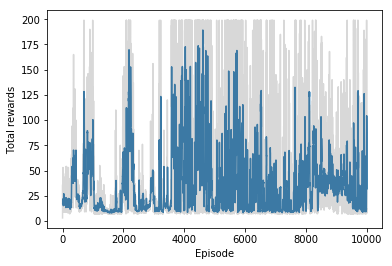

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

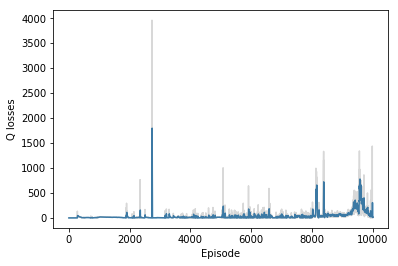

In [24]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

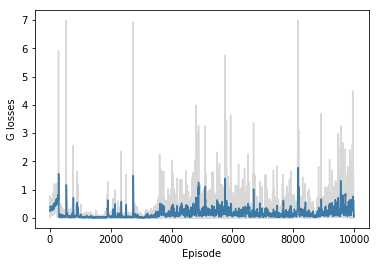

In [25]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

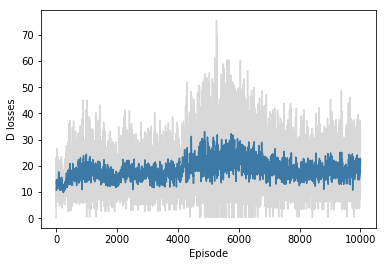

In [26]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [27]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [28]:
# # Closing the env
# # WARNING: If you close, you can NOT restart again!!!!!!
# env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.